# Multivariate regression for attention: exploring attrition

In this notebook, we shall conduct regression analysis to look at the effect of different variables on the attrition. But our main goal is to understand attention and to explore attention threshold. 

Note: This is after rematching i.e. when we decided to re-run the entire analysis properly defining the filtered sample. 

**Outcome Variable:**

Attrition rate

**Independent Variables:**

1. Gender
2. Scientist’s (binned) academic age at the time of retraction
3. Number of (binned) citations prior to retraction
4. Number of (binned) collaborators prior to retraction
5. Number of (binned) papers published up to retraction
6. (Aggregated) Field
7. Author contribution rank in the paper i.e. first or last or middle
8. Retraction year
9. Retraction reason
10. Retracted paper published in journal or conference
11. Journal impact factor (or rank)
12. Affiliation rank at the time of retraction
13. Number of authors in the retracted paper
14. **Attention given to the paper i.e. number of mentions within the 12 month retraction window. This will be computed and added in multiple mutually exclusive ways:**
    1. **(Tertiarized/Binarized) Altmetric score**
    2. **(Tertiarized/Binarized) mentions from four types of sources all entered separately into the regression model.**
    3. **Optionally (Tertiarized/Binarized) mentions from 14 different sources all entered separately into the regression model.**

In [1]:
# Importing relevant libraries

import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import math
import numpy as np

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Reading the regression file

df_main = pd.read_csv("/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_openalex/retraction_effects_on_academic_careers/data/processed/RW_authors_w_confounders_filteredSample_postNHB.csv")
df_main = df_main[df_main['nRetracted'] == 1]
# Let us define the dependent variable

Yi = 'AttritedClass'
Yroot = 'attritionClusteredLogisticwSJR'

df_main.MAGAID.nunique()

/var/folders/bf/_6xjm2bn2_n17hfhskyq1pmw0000gp/T/ipykernel_29880/650715258.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv("/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_openalex/retraction_effects_on_academic_careers/data/processed/RW_authors_w_confounders_filteredSample_postNHB.csv")


14579

In [4]:
# Removing class that's neither attrited nor non-attrited (i.e. those that are attrited due to something else)
df_main = df_main[df_main.AttritedClass.isin([0,1])]

df_main.MAGAID.nunique()

11677

In [5]:
# Checking how many attrited and how many not attrited
df_main[['MAGAID','AttritedClass']].drop_duplicates().AttritedClass.value_counts()

AttritedClass
0    9174
1    2503
Name: count, dtype: int64

In [6]:
# Defining attention columns

attention_agg_cols = ['AltmetricScoreAtRetraction',
                     'AggregateSocialMediaMentionsAtRetraction',
                     'AggregateNewsMediaMentionsAtRetraction',
                     'AggregateBlogsMentionsAtRetraction',
                     'AggregateKnowledgeRepositoriesMentionsAtRetraction']

# Creating the relevant dataframe
df = df_main[['Record ID','MAGAID'] + [Yi,'AttritedClassRobust']+
                 ['GenderizeGender',
                 'AcademicAgeAtRetraction',
                 'MAGCumPapersAtRetraction',
                 'LogMAGCumCitationsAtRetraction',
                 'LogMAGCumCollaboratorsAtRetraction']+
                list(df_main.\
                    filter(regex=("Field_.*")).columns)+
                ['MAGAIDRankTypeInRetractedPaper',
                'RetractionYear',
                'ReasonPropagatedMajorityOfMajority',
                'MAGJournalType',
                'SJRQuartileRetractedPaperYear',
                'MAGRetractionYearAffRankOrdinal',
                'NumAuthorsInRetractedPaper']+
                attention_agg_cols].drop_duplicates()

df

Record ID      MAGAID  AttritedClass  AttritedClassRobust  \
5           3294  1986180616              0                    0   
8           3489  2134970185              0                    0   
9           3631  2600580187              0                    0   
11          2202   257122240              0                    0   
13          4220  2160176121              0                    0   
...          ...         ...            ...                  ...   
34805       8239  2058168140              0                    0   
34811      18419   314964646              0                    0   
34812       8339  2333506346              0                    0   
34821      16484   384584067              0                    0   
34858      17209  2100934451              0                    1   

      GenderizeGender  AcademicAgeAtRetraction  MAGCumPapersAtRetraction  \
5                male                     17.0                       109   
8                male                     20.0                       253   
9                male                      7.0                        29   
11               male                     25.0                       252   
13               male                     28.0                       151   
...               ...                      ...                       ...   
34805            male                      4.0                        19   
34811            male                      1.0                         7   
34812            male                      0.0                         2   
34821            male                      7.0                         8   
34858            male                      5.0                        18   

       LogMAGCumCitationsAtRetraction  LogMAGCumCollaboratorsAtRetraction  \
5                            7.299121                            5.509388   
8                            7.584265                            5.826000   
9                            6.354370                            3.135494   
11                           8.518992                            5.521461   
13                           7.880426                            5.961005   
...                               ...                                 ...   
34805                        2.197225                            3.044522   
34811                        0.000000                            1.791759   
34812                        0.000000                            1.386294   
34821                        1.609438                            2.484907   
34858                        1.386294                            0.000000   

       Field_art  ...  ReasonPropagatedMajorityOfMajority  MAGJournalType  \
5              0  ...                          misconduct         journal   
8              0  ...                             mistake         journal   
9              0  ...                             mistake         journal   
11             0  ...                          misconduct         journal   
13             0  ...                               other         journal   
...          ...  ...                                 ...             ...   
34805          0  ...                          misconduct             NaN   
34811          1  ...                          plagiarism         journal   
34812          0  ...                               other         journal   
34821          0  ...                             mistake         journal   
34858          1  ...                          plagiarism         journal   

       SJRQuartileRetractedPaperYear  MAGRetractionYearAffRankOrdinal  \
5                                NaN                            175.0   
8                                NaN                           1500.0   
9                                NaN                             28.0   
11                               NaN                              1.0   
13                               NaN                          

In [7]:
df.GenderizeGender.value_counts()

GenderizeGender
male      8557
female    3120
Name: count, dtype: int64

In [8]:
df['ReasonPropagatedMajorityOfMajority'].value_counts()

ReasonPropagatedMajorityOfMajority
plagiarism    3366
mistake       3323
misconduct    2545
other         2443
Name: count, dtype: int64

In [9]:
df.dropna().shape

(8329, 40)

## Running Multivariate Regressions

In [10]:
def regress(df, equation):
    df = df.dropna()
    return smf.logit(Yi + "~ "+equation, data=df, missing='drop').fit(cov_type='cluster',
                                                                      cov_kwds={'groups':df['Record ID']})



In [11]:
# Defining dictionary that goes from field id to expression

expression_dict = {
        "age": "AcademicAgeAtRetraction",
        "gender": "C(GenderizeGender, Treatment(reference='male'))",
        "yearofretraction": "RetractionYear",
        "logcitations":"LogMAGCumCitationsAtRetraction",
        "logcollaborators":"LogMAGCumCollaboratorsAtRetraction",
        "papers":"MAGCumPapersAtRetraction",
        "reasons":"C(ReasonPropagatedMajorityOfMajority, Treatment(reference='mistake'))",
        "affrank":"MAGRetractionYearAffRankOrdinal",
        "contributionrank":"C(MAGAIDRankTypeInRetractedPaper, Treatment(reference='First or Last or Only Author'))",
        "numauthors":"NumAuthorsInRetractedPaper",
        "venue":"C(MAGJournalType, Treatment(reference='conference'))",
        "impactfactor":"SJRQuartileRetractedPaperYear",
        "field": " + ".join(list(df_main.filter(regex=("Field_.*")).columns))
}


fieldid_to_fieldname = {
        "age": ["AcademicAgeAtRetraction"],
        "gender": ["GenderizeGender"],
        "yearofretraction": ["RetractionYear"],
        "logcitations":["LogMAGCumCitationsAtRetraction"],
        "logcollaborators":["LogMAGCumCollaboratorsAtRetraction"],
        "papers":["MAGCumPapersAtRetraction"],
        "reasons":["ReasonPropagatedMajorityOfMajority"],
        "affrank":["MAGRetractionYearAffRankOrdinal"],
        "contributionrank":["MAGAIDRankTypeInRetractedPaper"],
        "numauthors":["NumAuthorsInRetractedPaper"],
        "venue":["MAGJournalType"],
        "impactfactor":["SJRQuartileRetractedPaperYear"],
        "field": list(df_main.filter(regex=("Field_.*")).columns)
}

In [12]:
# Academic Age
def age():
    global equation, ests, data
    field_id = "age"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Year of retraction
def yearofretraction():
    global equation, ests, data
    field_id = "yearofretraction"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of citations
def logcitations():
    global equation, ests, data
    field_id = "logcitations"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of collaborators
def logcollaborators():
    global equation, ests, data
    field_id = "logcollaborators"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of papers
def papers():
    global equation, ests, data
    field_id = "papers"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Gender
def gender():
    global equation, ests, data
    field_id = "gender"
    equation = equation + " + " + expression_dict.get(field_id)
    # Cleaning gender
    data = data[data.GenderizeGender.isin(['male','female'])]
    est = regress(data, equation)
    ests.append(est)

# Reason of retraction
def reasons():
    global equation, ests, data
    field_id = "reasons"
    equation = equation + " + " + expression_dict.get(field_id)
    # Cleaning reasons
    #data = data[data.ReasonPropagatedMajorityOfMajority.isin(['M','P','H'])]
    est = regress(data, equation)
    ests.append(est)

# Author affiliation rank 
def affrank():
    global equation, ests, data
    field_id = "affrank"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Author contribution rank
def contributionrank():
    global equation, ests, data
    field_id = "contributionrank"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Number of authors in the paper
def numauthors():
    global equation, ests, data
    field_id = "numauthors"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Journal or conference
def venue():
    global equation, ests, data
    field_id = "venue"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)

# Field
def field():
    global equation, ests, data
    field_id = "field"
    equation = equation + " + " + expression_dict.get(field_id)
    est = regress(data, equation)
    ests.append(est)
    
def regress_one_by_one(attention_expression, funcs):
    """
    In this function, we shall look at the effect of 
    attention on attrition while controlling for other 
    variables. We shall, however, add the controls one by one.
    """
    global equation, ests, data
    
    # We will save out estimators in a list
    ests = []
    
    # Initializing data
    data = df.copy()
    
    # Attention is our key variable, so we fix that
    
    equation = attention_expression
    
    est = regress(data, equation)
    
    ests.append(est)
    
    for func in funcs:
        func()
    
    return ests

def regress_all_together(dfi, attention_field, attention_expression, field_ids):
    """
    In this function, we shall run one regression with all the 
    controls given as func_ids
    """
    
    # Initializing the equation
    equation = attention_expression
    
    for field_id in field_ids:
        equation = equation + " + " + expression_dict.get(field_id)
        
    data = dfi.copy()
    
    # Fields to keep
    fields_to_keep = []
    for fid in field_ids:
        fields_to_keep += fieldid_to_fieldname.get(fid)
    
    print("Fields we keep for this regresion",fields_to_keep)
    
    data = data[['MAGAID','Record ID', attention_field, Yi]+fields_to_keep].drop_duplicates()
    
    # Cleaning if needed
#     if "gender" in field_ids:
#         # Cleaning gender
#         data = data[data.GenderizeGender.isin(['male','female'])]

#     if "reasons" in field_ids:
#         data = data[data.ReasonPropagatedMajorityOfMajority.isin(['M','P','H'])]
        
    est = regress(data, equation)
    
    return est

### Regression with raw scores

#### Regression with raw altmetric score (w/ one of the experience fields at a time)

In [13]:
default_fids = ["yearofretraction", "gender", "contributionrank", "venue", "impactfactor",
             "reasons", "field", "affrank", "numauthors",]

alternating_fids = ["age", "papers", "logcitations", "logcollaborators"]

attention_field = "AltmetricScoreAtRetraction"
attention_expression = attention_field

ests = []

for alt_fid in alternating_fids:
    est = regress_all_together(df.copy(), attention_field, attention_expression, default_fids + [alt_fid])
    ests.append(est)

Stargazer(ests)

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Field_business', 'Field_chemistry', 'Field_computerscience', 'Field_economics', 'Field_engineering', 'Field_environmentalscience', 'Field_geography', 'Field_geology', 'Field_history', 'Field_materialsscience', 'Field_mathematics', 'Field_medicine', 'Field_philosophy', 'Field_physics', 'Field_politicalscience', 'Field_psychology', 'Field_sociology', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.378848
         Iterations 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_art', 'Field_biology', 'Fie

### Regression with discretized scores

In [14]:
def discretize_attention_binary(score, threshold_high=5):
    if score < threshold_high:
        return "low attention"
    elif score >= threshold_high:
        return "high attention"
        
def discretize_attention_tertiary(score, threshold_medium=3, threshold_high=5):
    assert(threshold_medium < threshold_high)
    if score < threshold_medium:
        return "low attention"
    elif score >= threshold_medium and score < threshold_high:
        return "medium attention"
    elif score >= threshold_high:
        return "high attention"

#### Defining default and alternating fields

In [15]:
default_fids = ["yearofretraction", "gender", "contributionrank", "venue", "impactfactor",
             "reasons", "field", "affrank", "numauthors",]

alternating_fids = ["age", "papers", "logcitations", "logcollaborators"]

funcOrder = [age, yearofretraction, gender, contributionrank, venue, 
             reasons, field, logcitations, logcollaborators, papers, 
             affrank, numauthors,]

### Finding optimal threshold for discretizing attention

#### Understanding numerical bounds

Let us first see the limit i.e. upper bound we need to explore for each type of mention.

In [16]:
# Upper bound for Altmetric Score 
ub_altmetric = int(df['AltmetricScoreAtRetraction'].quantile(.99))
ub_altmetric

73

<AxesSubplot:>

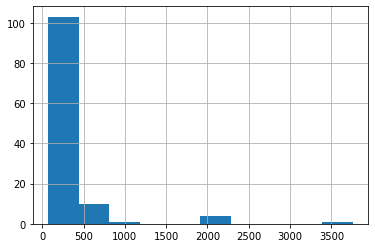

In [17]:
df[df['AltmetricScoreAtRetraction'].gt(ub_altmetric)].AltmetricScoreAtRetraction.hist()

In [19]:
df[df['AltmetricScoreAtRetraction'].gt(ub_altmetric)].AltmetricScoreAtRetraction.\
    value_counts().reset_index().sort_values(by='AltmetricScoreAtRetraction')


AltmetricScoreAtRetraction  count
15                       73.75      2
13                       74.00      3
11                       81.00      4
3                        86.00      8
23                       88.75      1
18                       92.25      2
20                       93.25      2
16                       96.75      2
9                        97.00      5
0                       101.25     13
8                       105.25      5
30                      109.75      1
1                       117.50     12
6                       124.25      6
24                      126.00      1
7                       133.50      6
21                      137.25      1
25                      158.25      1
17                      170.75      2
26                      175.00      1
4                       185.00      7
22                      191.75      1
12                      195.75      4
27                      197.25      1
19                      212.25      2
2                       333.25     10
14                      454.50      3
5                       767.00      7
29                     1097.00      1
10                     2232.75      4
28                     3756.50      1

In [20]:
# Upper bound for social media mentions
ub_socialmedia = int(df['AggregateSocialMediaMentionsAtRetraction'].quantile(.99))
ub_socialmedia

51

<AxesSubplot:>

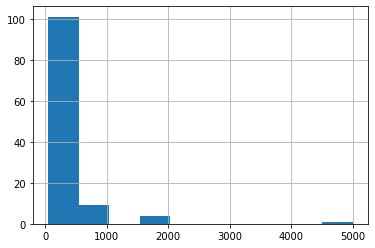

In [21]:
df[df['AggregateSocialMediaMentionsAtRetraction'].gt(ub_socialmedia)].AggregateSocialMediaMentionsAtRetraction.hist()

In [22]:
df[df['AggregateSocialMediaMentionsAtRetraction'].gt(ub_socialmedia)].AggregateSocialMediaMentionsAtRetraction.\
    value_counts().reset_index().sort_values(by='AggregateSocialMediaMentionsAtRetraction')

AggregateSocialMediaMentionsAtRetraction  count
0                                       52.0     13
25                                      55.0      1
11                                      56.0      4
18                                      57.0      2
17                                      61.0      2
15                                      65.0      2
14                                      66.0      2
8                                       74.0      6
2                                       75.0     10
3                                       76.0     10
1                                       87.0     12
13                                      92.0      3
10                                     114.0      4
7                                      123.0      6
4                                      131.0      8
16                                     133.0      2
5                                      139.0      7
24                                     159.0      1
22                                     249.0      1
26                                     253.0      1
12                                     282.0      3
20                                     355.0      1
23                                     647.0      1
6                                      707.0      7
19                                     858.0      1
9                                     1898.0      4
21                                    4995.0      1

In [23]:
# Upper bound for news media mentions
ub_newsmedia = int(df['AggregateNewsMediaMentionsAtRetraction'].quantile(.99))
ub_newsmedia

3

In [22]:
# Upper bound for news media mentions
ub_blogs = int(df['AggregateBlogsMentionsAtRetraction'].quantile(.99))
ub_blogs

5

In [23]:
# Upper bound for knowledge repositories
ub_kr = int(df['AggregateKnowledgeRepositoriesMentionsAtRetraction'].quantile(.99))
ub_kr

7

In [24]:
def explore_thresholds_binary_helper(dfi, experience_fields, attention_field, ub):
    
    print("Exploring following experience fields:", experience_fields)
        
    # This is the dictionary we shall add return threshold --> [coeff, pvalue]

    threshold_to_coefs = {}
    regressors = []
    
    # Going through each threshold
    for threshold_high in range(1,ub+1):
        
        print("Threshold high:",threshold_high)
        
        # Discretizing the current attention field into binary based on the current threshold
        dfi['Binary'+attention_field] = dfi.apply(lambda row: \
                                        discretize_attention_binary(row[attention_field],threshold_high),
                                        axis=1)
        
        # Describing the attention expression
        attention_exp = "C(Binary"+attention_field+", Treatment('low attention'))"
        
        # Finally regressing
        est = regress_all_together(dfi, 'Binary'+attention_field, attention_exp, default_fids + experience_fields)
        
        # Saving the regression coefficients for attention 
        threshold_to_coefs[threshold_high] = [est.params[attention_exp+'[T.high attention]'],
                                              est.pvalues[attention_exp+'[T.high attention]']]
        
        # Saving the regressor
        regressors.append(est)
        
    return threshold_to_coefs, regressors

In [25]:
def explore_thresholds_binary(attention_field, ub):
    
    # We will run this function for all the different kinds of experience fields together and one by one
    
    # Copying the df locally
    dfi = df.copy()
    
    # The dictionary we shall populate for each variant of model
    exp_field_to_threshold_dicts = {}
    
    # Going through each experience field
    for alt_fid in alternating_fids:
        
        experience_fields = [alt_fid]
        
        threshold_to_coefs, regressors = explore_thresholds_binary_helper(dfi, experience_fields, attention_field, ub)
        
        exp_field_to_threshold_dicts[alt_fid] = threshold_to_coefs
        
    return exp_field_to_threshold_dicts, regressors

In [26]:
def explore_threshold_tertiary_helper(dfi, experience_fields, attention_field, ub,
                                     reference_category="medium attention"):
    
    print("Exploring field:",alt_fid)
    
    threshold_to_coefs = {}
    
    ests = []
    
    middle_high = [(a, b) for a in range(1,ub) for b in range(ub) if a < b]
    
    # Going through each pair of middle and high attention threshold
    for medium,high in middle_high:
        
        print("Threshold medium:",medium,", high:",high)
        
        # Discretizing attention
        dfi['Tertiary'+attention_field] = dfi.apply(lambda row: \
                                        discretize_attention_tertiary(row[attention_field],medium,high),
                                        axis=1)
        
        # We use try due to sparsity as thresholds increase (due to skewness of attention distribution)
        
        try:
            attention_exp = "C(Tertiary"+attention_field+", Treatment('"+reference_category+"'))"

            est = regress_all_together(dfi, 'Tertiary'+attention_field, attention_exp, default_fids + experience_fields)
            #ests.append(est)
            
            if(reference_category == "medium attention"):
            
                threshold_to_coefs[(medium,high)] = [(est.params[attention_exp+'[T.low attention]'],
                                                      est.pvalues[attention_exp+'[T.low attention]']),
                                                    (est.params[attention_exp+'[T.high attention]'],
                                                      est.pvalues[attention_exp+'[T.high attention]'])]
                
            elif(reference_category == "low attention"):
                
                threshold_to_coefs[(medium,high)] = [(est.params[attention_exp+'[T.medium attention]'],
                                                      est.pvalues[attention_exp+'[T.medium attention]']),
                                                    (est.params[attention_exp+'[T.high attention]'],
                                                      est.pvalues[attention_exp+'[T.high attention]'])]
                
        except:
            print("##################")
            print("Can't process", medium, high)
            print("##################")

    return threshold_to_coefs

In [27]:
def explore_thresholds_tertiary(attention_field, ub, reference_category="medium attention"):
    
    # We will run this function for all the different kinds of experience fields together and one by one
    
    dfi = df.copy()
    
    exp_field_to_threshold_dicts = {}
    
    for alt_fid in alternating_fids:
        
        experience_fields = [alt_fid]
        
        threshold_to_coefs = explore_threshold_tertiary_helper(dfi, experience_fields, attention_field, ub,
                                                              reference_category)
        
        exp_field_to_threshold_dicts[alt_fid] = threshold_to_coefs
            
    return exp_field_to_threshold_dicts

#### Finding threshold for altmetric score

In [28]:
dict_binary_altmetric, regressors_altmetric = explore_thresholds_binary("AltmetricScoreAtRetraction", ub_altmetric)

Exploring following experience fields: ['age']
Threshold high: 1
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409893
         Iterations 8
Threshold high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedP

Optimization terminated successfully.
         Current function value: 0.409440
         Iterations 8
Threshold high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409203
         Iterations 8
Threshold high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeIn

Optimization terminated successfully.
         Current function value: 0.409023
         Iterations 8
Threshold high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408928
         Iterations 8
Threshold high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeIn

Optimization terminated successfully.
         Current function value: 0.409607
         Iterations 7
Threshold high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409817
         Iterations 7
Threshold high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeIn

Optimization terminated successfully.
         Current function value: 0.409908
         Iterations 7
Threshold high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409908
         Iterations 7
Threshold high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeIn

Optimization terminated successfully.
         Current function value: 0.409907
         Iterations 8
Threshold high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409905
         Iterations 8
Threshold high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeIn

Optimization terminated successfully.
         Current function value: 0.380866
         Iterations 10
Threshold high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold high: 4
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeI

Optimization terminated successfully.
         Current function value: 0.380411
         Iterations 10
Threshold high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380383
         Iterations 10
Threshold high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTyp

Optimization terminated successfully.
         Current function value: 0.380658
         Iterations 10
Threshold high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380666
         Iterations 10
Threshold high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTyp

Optimization terminated successfully.
         Current function value: 0.380841
         Iterations 10
Threshold high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380860
         Iterations 10
Threshold high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTyp

Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTyp

Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTyp

Optimization terminated successfully.
         Current function value: 0.394650
         Iterations 7
Threshold high: 5
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394751
         Iterations 7
Threshold high: 6
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankT

Optimization terminated successfully.
         Current function value: 0.393631
         Iterations 7
Threshold high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393402
         Iterations 7
Threshold high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRan

Optimization terminated successfully.
         Current function value: 0.394076
         Iterations 7
Threshold high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394023
         Iterations 7
Threshold high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRan

Optimization terminated successfully.
         Current function value: 0.395114
         Iterations 7
Threshold high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395218
         Iterations 7
Threshold high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRan

Optimization terminated successfully.
         Current function value: 0.395300
         Iterations 7
Threshold high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395300
         Iterations 7
Threshold high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRan

Optimization terminated successfully.
         Current function value: 0.395342
         Iterations 7
Threshold high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395342
         Iterations 7
Threshold high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRan

Optimization terminated successfully.
         Current function value: 0.354723
         Iterations 8
Threshold high: 7
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354651
         Iterations 8
Threshold high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDR

Optimization terminated successfully.
         Current function value: 0.354042
         Iterations 8
Threshold high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354142
         Iterations 8
Threshold high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAI

Optimization terminated successfully.
         Current function value: 0.354353
         Iterations 8
Threshold high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354367
         Iterations 8
Threshold high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAI

Optimization terminated successfully.
         Current function value: 0.354884
         Iterations 8
Threshold high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354884
         Iterations 8
Threshold high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAI

Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAI

Optimization terminated successfully.
         Current function value: 0.354866
         Iterations 8
Threshold high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354866
         Iterations 8
Threshold high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAI

In [29]:
Stargazer(regressors_altmetric)

In [30]:
dict_binary_altmetric

{'age': {1: [0.038163519344573085, 0.6581559799803547],
  2: [0.07298879077167329, 0.39275842816658335],
  3: [0.09746729844104021, 0.25112179213347363],
  4: [0.10291511115542762, 0.23108862489176818],
  5: [0.08903772841674922, 0.2999918066563001],
  6: [0.07382168041988967, 0.42706575576314765],
  7: [0.10655878309776763, 0.25668277372463066],
  8: [0.1366576388804044, 0.14957313552460222],
  9: [0.1347379532684436, 0.16050127327819919],
  10: [0.1308471154373141, 0.17725262543095754],
  11: [0.28416040465308334, 0.017904804730627742],
  12: [0.36716218732513334, 0.0037342694774316243],
  13: [0.3456733962353356, 0.007289745538978247],
  14: [0.3895178086166948, 0.004331952895900038],
  15: [0.38444413417619044, 0.006704326783434155],
  16: [0.46888064680266234, 0.002433245255846919],
  17: [0.49928160498227364, 0.001603487886961962],
  18: [0.48661718377969365, 0.0027041233367612995],
  19: [0.5285464853420412, 0.0020654410135338337],
  20: [0.5599268265434314, 0.001331445845705452

In [31]:
# Getting dictionary for when reference category is medium attention

dict_tertiary_altmetric_mediumref = explore_thresholds_tertiary("AltmetricScoreAtRetraction", ub_altmetric)

Exploring field: logcollaborators
Threshold medium: 1 , high: 2
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409774
         Iterations 8
Threshold medium: 1 , high: 3
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartil

Optimization terminated successfully.
         Current function value: 0.409177
         Iterations 8
Threshold medium: 1 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409298
         Iterations 8
Threshold medium: 1 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.408926
         Iterations 8
Threshold medium: 1 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409524
         Iterations 8
Threshold medium: 1 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409809
         Iterations 8
Threshold medium: 1 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409818
         Iterations 8
Threshold medium: 1 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409892
         Iterations 8
Threshold medium: 1 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409888
         Iterations 8
Threshold medium: 1 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409890
         Iterations 8
Threshold medium: 1 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409890
         Iterations 8
Threshold medium: 1 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409842
         Iterations 8
Threshold medium: 2 , high: 7
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409805
         Iterations 8
Threshold medium: 2 , high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGend

Optimization terminated successfully.
         Current function value: 0.408992
         Iterations 8
Threshold medium: 2 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409093
         Iterations 8
Threshold medium: 2 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409326
         Iterations 8
Threshold medium: 2 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409326
         Iterations 8
Threshold medium: 2 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409848
         Iterations 8
Threshold medium: 2 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409848
         Iterations 8
Threshold medium: 2 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409849
         Iterations 8
Threshold medium: 2 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409848
         Iterations 8
Threshold medium: 2 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409846
         Iterations 8
Threshold medium: 2 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409846
         Iterations 8
Threshold medium: 2 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409203
         Iterations 8
Threshold medium: 3 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409312
         Iterations 8
Threshold medium: 3 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.408912
         Iterations 8
Threshold medium: 3 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409478
         Iterations 8
Threshold medium: 3 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409735
         Iterations 8
Threshold medium: 3 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409743
         Iterations 8
Threshold medium: 3 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409801
         Iterations 8
Threshold medium: 3 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409800
         Iterations 8
Threshold medium: 3 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409800
         Iterations 8
Threshold medium: 3 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409800
         Iterations 8
Threshold medium: 3 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409735
         Iterations 8
Threshold medium: 4 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409740
         Iterations 8
Threshold medium: 4 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGen

Optimization terminated successfully.
         Current function value: 0.409010
         Iterations 8
Threshold medium: 4 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408931
         Iterations 8
Threshold medium: 4 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409317
         Iterations 8
Threshold medium: 4 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409317
         Iterations 8
Threshold medium: 4 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409784
         Iterations 8
Threshold medium: 4 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409789
         Iterations 8
Threshold medium: 4 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409791
         Iterations 8
Threshold medium: 4 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409791
         Iterations 8
Threshold medium: 4 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409786
         Iterations 8
Threshold medium: 5 , high: 6
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409821
         Iterations 8
Threshold medium: 5 , high: 7
Fields we keep for this regresion ['RetractionYear', 'GenderizeGend

Optimization terminated successfully.
         Current function value: 0.409066
         Iterations 8
Threshold medium: 5 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408992
         Iterations 8
Threshold medium: 5 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409302
         Iterations 8
Threshold medium: 5 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409316
         Iterations 8
Threshold medium: 5 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409814
         Iterations 8
Threshold medium: 5 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409819
         Iterations 8
Threshold medium: 5 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409820
         Iterations 8
Threshold medium: 5 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409821
         Iterations 8
Threshold medium: 5 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409820
         Iterations 8
Threshold medium: 5 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409817
         Iterations 8
Threshold medium: 5 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409161
         Iterations 8
Threshold medium: 6 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409223
         Iterations 8
Threshold medium: 6 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409514
         Iterations 8
Threshold medium: 6 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409364
         Iterations 8
Threshold medium: 6 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409838
         Iterations 8
Threshold medium: 6 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409835
         Iterations 8
Threshold medium: 6 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409857
         Iterations 8
Threshold medium: 6 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409858
         Iterations 8
Threshold medium: 6 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409859
         Iterations 8
Threshold medium: 6 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409859
         Iterations 8
Threshold medium: 6 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409291
         Iterations 8
Threshold medium: 7 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409193
         Iterations 8
Threshold medium: 7 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409505
         Iterations 8
Threshold medium: 7 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409497
         Iterations 8
Threshold medium: 7 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409761
         Iterations 8
Threshold medium: 7 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409794
         Iterations 8
Threshold medium: 7 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409807
         Iterations 8
Threshold medium: 7 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409807
         Iterations 8
Threshold medium: 7 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409808
         Iterations 8
Threshold medium: 7 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409808
         Iterations 8
Threshold medium: 7 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409309
         Iterations 8
Threshold medium: 8 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409210
         Iterations 8
Threshold medium: 8 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409476
         Iterations 8
Threshold medium: 8 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409468
         Iterations 8
Threshold medium: 8 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409709
         Iterations 8
Threshold medium: 8 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409737
         Iterations 8
Threshold medium: 8 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409746
         Iterations 8
Threshold medium: 8 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409746
         Iterations 8
Threshold medium: 8 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409746
         Iterations 8
Threshold medium: 8 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409745
         Iterations 8
Threshold medium: 8 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409206
         Iterations 8
Threshold medium: 9 , high: 15
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409259
         Iterations 8
Threshold medium: 9 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409474
         Iterations 8
Threshold medium: 9 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409334
         Iterations 8
Threshold medium: 9 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409744
         Iterations 8
Threshold medium: 9 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409742
         Iterations 8
Threshold medium: 9 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 8
Threshold medium: 9 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 8
Threshold medium: 9 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 8
Threshold medium: 9 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 8
Threshold medium: 9 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGe

Optimization terminated successfully.
         Current function value: 0.409056
         Iterations 8
Threshold medium: 10 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408981
         Iterations 8
Threshold medium: 10 , high: 18
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409304
         Iterations 8
Threshold medium: 10 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409318
         Iterations 8
Threshold medium: 10 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409763
         Iterations 8
Threshold medium: 10 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409756
         Iterations 8
Threshold medium: 10 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409764
         Iterations 8
Threshold medium: 10 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409763
         Iterations 8
Threshold medium: 10 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409764
         Iterations 8
Threshold medium: 10 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409754
         Iterations 8
Threshold medium: 10 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409006
         Iterations 8
Threshold medium: 11 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408929
         Iterations 8
Threshold medium: 11 , high: 21
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409196
         Iterations 8
Threshold medium: 11 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409196
         Iterations 8
Threshold medium: 11 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409372
         Iterations 8
Threshold medium: 11 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409394
         Iterations 8
Threshold medium: 11 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409418
         Iterations 8
Threshold medium: 11 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409418
         Iterations 8
Threshold medium: 11 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409395
         Iterations 8
Threshold medium: 12 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409188
         Iterations 8
Threshold medium: 12 , high: 14
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408816
         Iterations 8
Threshold medium: 12 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409155
         Iterations 8
Threshold medium: 12 , high: 25
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409201
         Iterations 8
Threshold medium: 12 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409199
         Iterations 8
Threshold medium: 12 , high: 36
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409143
         Iterations 8
Threshold medium: 12 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409163
         Iterations 8
Threshold medium: 12 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409165
         Iterations 8
Threshold medium: 12 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409165
         Iterations 8
Threshold medium: 12 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408993
         Iterations 8
Threshold medium: 13 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409079
         Iterations 8
Threshold medium: 13 , high: 19
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409138
         Iterations 8
Threshold medium: 13 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409130
         Iterations 8
Threshold medium: 13 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409218
         Iterations 8
Threshold medium: 13 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409218
         Iterations 8
Threshold medium: 13 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409268
         Iterations 8
Threshold medium: 13 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409271
         Iterations 8
Threshold medium: 13 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409241
         Iterations 8
Threshold medium: 13 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409241
         Iterations 8
Threshold medium: 13 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408860
         Iterations 8
Threshold medium: 14 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409186
         Iterations 8
Threshold medium: 14 , high: 25
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409208
         Iterations 8
Threshold medium: 14 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409205
         Iterations 8
Threshold medium: 14 , high: 36
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409138
         Iterations 8
Threshold medium: 14 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409161
         Iterations 8
Threshold medium: 14 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409166
         Iterations 8
Threshold medium: 14 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409166
         Iterations 8
Threshold medium: 14 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409013
         Iterations 8
Threshold medium: 15 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408936
         Iterations 8
Threshold medium: 15 , high: 21
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409132
         Iterations 8
Threshold medium: 15 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409132
         Iterations 8
Threshold medium: 15 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409114
         Iterations 8
Threshold medium: 15 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409152
         Iterations 8
Threshold medium: 15 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409201
         Iterations 8
Threshold medium: 15 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409201
         Iterations 8
Threshold medium: 15 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409168
         Iterations 7
Threshold medium: 16 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408991
         Iterations 8
Threshold medium: 16 , high: 18
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409006
         Iterations 8
Threshold medium: 16 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409009
         Iterations 8
Threshold medium: 16 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408940
         Iterations 8
Threshold medium: 16 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408852
         Iterations 8
Threshold medium: 16 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408963
         Iterations 8
Threshold medium: 16 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408953
         Iterations 8
Threshold medium: 16 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408972
         Iterations 8
Threshold medium: 16 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408919
         Iterations 8
Threshold medium: 16 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408992
         Iterations 8
Threshold medium: 17 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408970
         Iterations 8
Threshold medium: 17 , high: 27
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408866
         Iterations 8
Threshold medium: 17 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408876
         Iterations 8
Threshold medium: 17 , high: 38
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408867
         Iterations 8
Threshold medium: 17 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408867
         Iterations 8
Threshold medium: 17 , high: 49
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408879
         Iterations 8
Threshold medium: 17 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408879
         Iterations 8
Threshold medium: 17 , high: 60
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409092
         Iterations 8
Threshold medium: 18 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409093
         Iterations 8
Threshold medium: 18 , high: 26
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409021
         Iterations 8
Threshold medium: 18 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408966
         Iterations 8
Threshold medium: 18 , high: 37
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408969
         Iterations 8
Threshold medium: 18 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408969
         Iterations 8
Threshold medium: 18 , high: 48
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408984
         Iterations 8
Threshold medium: 18 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408982
         Iterations 8
Threshold medium: 18 , high: 59
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409003
         Iterations 8
Threshold medium: 19 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409009
         Iterations 8
Threshold medium: 19 , high: 26
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 8
Threshold medium: 19 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408831
         Iterations 8
Threshold medium: 19 , high: 37
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408852
         Iterations 8
Threshold medium: 19 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408852
         Iterations 8
Threshold medium: 19 , high: 48
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408875
         Iterations 8
Threshold medium: 19 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408873
         Iterations 8
Threshold medium: 19 , high: 59
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408907
         Iterations 8
Threshold medium: 20 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408938
         Iterations 8
Threshold medium: 20 , high: 27
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408701
         Iterations 8
Threshold medium: 20 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408716
         Iterations 8
Threshold medium: 20 , high: 38
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408738
         Iterations 8
Threshold medium: 20 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408744
         Iterations 8
Threshold medium: 20 , high: 49
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408766
         Iterations 8
Threshold medium: 20 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408766
         Iterations 8
Threshold medium: 20 , high: 60
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408933
         Iterations 8
Threshold medium: 21 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408932
         Iterations 8
Threshold medium: 21 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408495
         Iterations 8
Threshold medium: 21 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408368
         Iterations 8
Threshold medium: 21 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408655
         Iterations 8
Threshold medium: 21 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408644
         Iterations 8
Threshold medium: 21 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408691
         Iterations 8
Threshold medium: 21 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408608
         Iterations 8
Threshold medium: 21 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409022
         Iterations 8
Threshold medium: 22 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409022
         Iterations 8
Threshold medium: 22 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408466
         Iterations 8
Threshold medium: 22 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408566
         Iterations 8
Threshold medium: 22 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408751
         Iterations 8
Threshold medium: 22 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408751
         Iterations 8
Threshold medium: 22 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408704
         Iterations 8
Threshold medium: 23 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408500
         Iterations 8
Threshold medium: 23 , high: 25
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408539
         Iterations 8
Threshold medium: 23 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408527
         Iterations 8
Threshold medium: 23 , high: 36
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408516
         Iterations 8
Threshold medium: 23 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408582
         Iterations 8
Threshold medium: 23 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408641
         Iterations 8
Threshold medium: 23 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408641
         Iterations 8
Threshold medium: 23 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409235
         Iterations 7
Threshold medium: 24 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409308
         Iterations 7
Threshold medium: 24 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409161
         Iterations 8
Threshold medium: 24 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409161
         Iterations 8
Threshold medium: 24 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409362
         Iterations 8
Threshold medium: 24 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409370
         Iterations 8
Threshold medium: 24 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409325
         Iterations 8
Threshold medium: 24 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409325
         Iterations 8
Threshold medium: 24 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409092
         Iterations 7
Threshold medium: 25 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409202
         Iterations 7
Threshold medium: 25 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409248
         Iterations 8
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409128
         Iterations 8
Threshold medium: 25 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409354
         Iterations 8
Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409344
         Iterations 8
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409376
         Iterations 8
Threshold medium: 25 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409307
         Iterations 8
Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409037
         Iterations 8
Threshold medium: 26 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409026
         Iterations 8
Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409029
         Iterations 8
Threshold medium: 26 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409093
         Iterations 8
Threshold medium: 26 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409145
         Iterations 8
Threshold medium: 26 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409145
         Iterations 8
Threshold medium: 26 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409325
         Iterations 8
Threshold medium: 27 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409327
         Iterations 8
Threshold medium: 27 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408804
         Iterations 8
Threshold medium: 27 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408880
         Iterations 8
Threshold medium: 27 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409042
         Iterations 8
Threshold medium: 27 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409042
         Iterations 8
Threshold medium: 27 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409332
         Iterations 8
Threshold medium: 28 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409338
         Iterations 8
Threshold medium: 28 , high: 31
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408681
         Iterations 8
Threshold medium: 28 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408685
         Iterations 8
Threshold medium: 28 , high: 42
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 8
Threshold medium: 28 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 8
Threshold medium: 28 , high: 53
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409011
         Iterations 8
Threshold medium: 28 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409011
         Iterations 8
Threshold medium: 29 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408565
         Iterations 8
Threshold medium: 29 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408565
         Iterations 8
Threshold medium: 29 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409006
         Iterations 8
Threshold medium: 29 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409020
         Iterations 8
Threshold medium: 29 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408975
         Iterations 8
Threshold medium: 29 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408975
         Iterations 8
Threshold medium: 29 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408586
         Iterations 8
Threshold medium: 30 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408586
         Iterations 8
Threshold medium: 30 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409033
         Iterations 8
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409046
         Iterations 8
Threshold medium: 30 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409001
         Iterations 8
Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409001
         Iterations 8
Threshold medium: 30 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408586
         Iterations 8
Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408603
         Iterations 8
Threshold medium: 31 , high: 42
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409046
         Iterations 8
Threshold medium: 31 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409046
         Iterations 8
Threshold medium: 31 , high: 53
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409001
         Iterations 8
Threshold medium: 31 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409001
         Iterations 8
Threshold medium: 32 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.408792
         Iterations 8
Threshold medium: 32 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.408886
         Iterations 8
Threshold medium: 32 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409079
         Iterations 8
Threshold medium: 32 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409079
         Iterations 8
Threshold medium: 32 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409077
         Iterations 8
Threshold medium: 33 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409102
         Iterations 8
Threshold medium: 33 , high: 36
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409314
         Iterations 8
Threshold medium: 33 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409381
         Iterations 8
Threshold medium: 33 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409433
         Iterations 7
Threshold medium: 33 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409433
         Iterations 7
Threshold medium: 33 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409683
         Iterations 7
Threshold medium: 34 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409560
         Iterations 7
Threshold medium: 34 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409759
         Iterations 7
Threshold medium: 34 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409749
         Iterations 7
Threshold medium: 34 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409768
         Iterations 7
Threshold medium: 34 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409715
         Iterations 7
Threshold medium: 34 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409705
         Iterations 7
Threshold medium: 35 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409738
         Iterations 7
Threshold medium: 35 , high: 45
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409771
         Iterations 7
Threshold medium: 35 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409771
         Iterations 7
Threshold medium: 35 , high: 56
Fields we keep for this regresion ['RetractionYear', 'Genderize

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409839
         Iterations 7
Threshold medium: 36 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409725
         Iterations 7
Threshold medium: 36 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409856
         Iterations 7
Threshold medium: 36 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409849
         Iterations 7
Threshold medium: 36 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409858
         Iterations 7
Threshold medium: 36 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409820
         Iterations 7
Threshold medium: 36 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409824
         Iterations 7
Threshold medium: 37 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409849
         Iterations 7
Threshold medium: 37 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409853
         Iterations 7
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409853
         Iterations 7
Threshold medium: 37 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409839
         Iterations 7
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409864
         Iterations 7
Threshold medium: 38 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409888
         Iterations 7
Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409888
         Iterations 7
Threshold medium: 38 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Genderize

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409892
         Iterations 7
Threshold medium: 39 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'F

Optimization terminated successfully.
         Current function value: 0.409899
         Iterations 7
Threshold medium: 39 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409899
         Iterations 7
Threshold medium: 39 , high: 53
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409908
         Iterations 7
Threshold medium: 39 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409908
         Iterations 7
Threshold medium: 40 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409902
         Iterations 7
Threshold medium: 40 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409899
         Iterations 7
Threshold medium: 40 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409908
         Iterations 7
Threshold medium: 40 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409908
         Iterations 7
Threshold medium: 40 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

/usr/local/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35
Threshold medium: 41 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409865
         Iterations 7
Threshold medium: 41 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper'

Optimization terminated successfully.
         Current function value: 0.409881
         Iterations 7
Threshold medium: 41 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409881
         Iterations 7
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409904
         Iterations 7
Threshold medium: 42 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409898
         Iterations 7
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 42 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409902
         Iterations 7
Threshold medium: 43 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409855
         Iterations 7
Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409898
         Iterations 7
Threshold medium: 43 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409898
         Iterations 7
Threshold medium: 43 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409799
         Iterations: 35
Threshold medium: 44 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 8
Threshold medium: 44 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 8
Threshold medium: 44 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409906
         Iterations 7
Threshold medium: 44 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409906
         Iterations 7
Threshold medium: 44 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Genderize

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409799
         Iterations: 35
Threshold medium: 45 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 8
Threshold medium: 45 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 8
Threshold medium: 45 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409906
         Iterations 7
Threshold medium: 45 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409906
         Iterations 7
Threshold medium: 45 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409897
         Iterations 8
Threshold medium: 46 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409897
         Iterations 8
Threshold medium: 46 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 8
Threshold medium: 47 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 8
Threshold medium: 47 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 47 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 47 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 48 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409905
         Iterations 7
Threshold medium: 48 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 49 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409901
         Iterations 7
Threshold medium: 49 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409858
         Iterations 7
Threshold medium: 50 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
         Current function value: 0.409895
         Iterations: 35
Threshold medium: 50 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedP

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409895
         Iterations: 35
Threshold medium: 50 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409895
         Iterations: 35
Threshold medium: 50 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409895
         Iterations: 35
Threshold medium: 50 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409895
         Iterations: 35
Threshold medium: 50 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409892
         Iterations 7
Threshold medium: 50 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409892
         Iterations 7
Threshold medium: 50 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

##################
Can't process 51 55
##################
Threshold medium: 51 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409897
         Iterations 7
Threshold medium: 51 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', '

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409897
         Iterations 7
Threshold medium: 52 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'F

Optimization terminated successfully.
         Current function value: 0.409897
         Iterations 7
Threshold medium: 53 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409897
         Iterations 7
Threshold medium: 53 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409906
         Iterations 7
Threshold medium: 54 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409906
         Iterations 7
Threshold medium: 54 , high: 60
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409861
         Iterations 7
Threshold medium: 55 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409861
         Iterations 7
Threshold medium: 55 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409902
         Iterations 8
Threshold medium: 57 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409902
         Iterations 8
Threshold medium: 57 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.409764
         Iterations 7
Threshold medium: 59 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'AcademicAgeAtRetraction']
Optimization terminated successfully.
         Current function value: 0.409764
         Iterations 7
Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.380688
         Iterations 10
Threshold medium: 1 , high: 5
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380767
         Iterations 10
Threshold medium: 1 , high: 6
Fields we keep for this regresion ['RetractionYear', 'GenderizeG

Optimization terminated successfully.
         Current function value: 0.380412
         Iterations 10
Threshold medium: 1 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380287
         Iterations 10
Threshold medium: 1 , high: 17
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380559
         Iterations 10
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380537
         Iterations 10
Threshold medium: 1 , high: 28
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380856
         Iterations 10
Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 1 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380874
         Iterations 10
Threshold medium: 1 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380874
         Iterations 10
Threshold medium: 1 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 1 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 1 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380787
         Iterations 10
Threshold medium: 2 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380783
         Iterations 10
Threshold medium: 2 , high: 11
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380229
         Iterations 10
Threshold medium: 2 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380233
         Iterations 10
Threshold medium: 2 , high: 22
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380554
         Iterations 10
Threshold medium: 2 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380563
         Iterations 10
Threshold medium: 2 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380864
         Iterations 10
Threshold medium: 2 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380865
         Iterations 10
Threshold medium: 2 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380866
         Iterations 10
Threshold medium: 2 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380866
         Iterations 10
Threshold medium: 2 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380829
         Iterations 10
Threshold medium: 3 , high: 5
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380841
         Iterations 10
Threshold medium: 3 , high: 6
Fields we keep for this regresion ['RetractionYear', 'GenderizeG

Optimization terminated successfully.
         Current function value: 0.380457
         Iterations 10
Threshold medium: 3 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380330
         Iterations 10
Threshold medium: 3 , high: 17
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380564
         Iterations 10
Threshold medium: 3 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380543
         Iterations 10
Threshold medium: 3 , high: 28
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380832
         Iterations 10
Threshold medium: 3 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380843
         Iterations 10
Threshold medium: 3 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold medium: 3 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold medium: 3 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold medium: 3 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold medium: 3 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380512
         Iterations 10
Threshold medium: 4 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380275
         Iterations 10
Threshold medium: 4 , high: 13
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380286
         Iterations 10
Threshold medium: 4 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380191
         Iterations 10
Threshold medium: 4 , high: 24
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380698
         Iterations 10
Threshold medium: 4 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380808
         Iterations 10
Threshold medium: 4 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380832
         Iterations 10
Threshold medium: 4 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380832
         Iterations 10
Threshold medium: 4 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380834
         Iterations 10
Threshold medium: 4 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380835
         Iterations 10
Threshold medium: 4 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380787
         Iterations 10
Threshold medium: 5 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380794
         Iterations 10
Threshold medium: 5 , high: 10
Fields we keep for this regresion ['RetractionYear', 'Genderize

Optimization terminated successfully.
         Current function value: 0.380315
         Iterations 10
Threshold medium: 5 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380235
         Iterations 10
Threshold medium: 5 , high: 21
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380551
         Iterations 10
Threshold medium: 5 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380551
         Iterations 10
Threshold medium: 5 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380837
         Iterations 10
Threshold medium: 5 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380849
         Iterations 10
Threshold medium: 5 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380851
         Iterations 10
Threshold medium: 5 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380851
         Iterations 10
Threshold medium: 5 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380842
         Iterations 10
Threshold medium: 6 , high: 7
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380708
         Iterations 10
Threshold medium: 6 , high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeG

Optimization terminated successfully.
         Current function value: 0.380234
         Iterations 10
Threshold medium: 6 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380326
         Iterations 10
Threshold medium: 6 , high: 19
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380554
         Iterations 10
Threshold medium: 6 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380520
         Iterations 10
Threshold medium: 6 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380858
         Iterations 10
Threshold medium: 6 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380858
         Iterations 10
Threshold medium: 6 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380865
         Iterations 10
Threshold medium: 6 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380865
         Iterations 10
Threshold medium: 6 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380856
         Iterations 10
Threshold medium: 6 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380856
         Iterations 10
Threshold medium: 6 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380308
         Iterations 10
Threshold medium: 7 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380277
         Iterations 10
Threshold medium: 7 , high: 18
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380546
         Iterations 10
Threshold medium: 7 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380555
         Iterations 10
Threshold medium: 7 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380830
         Iterations 10
Threshold medium: 7 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380818
         Iterations 10
Threshold medium: 7 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380829
         Iterations 10
Threshold medium: 7 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380828
         Iterations 10
Threshold medium: 7 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380829
         Iterations 10
Threshold medium: 7 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380817
         Iterations 10
Threshold medium: 7 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380325
         Iterations 10
Threshold medium: 8 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380293
         Iterations 10
Threshold medium: 8 , high: 18
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380533
         Iterations 10
Threshold medium: 8 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380541
         Iterations 10
Threshold medium: 8 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380790
         Iterations 10
Threshold medium: 8 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380773
         Iterations 10
Threshold medium: 8 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380788
         Iterations 10
Threshold medium: 8 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380786
         Iterations 10
Threshold medium: 8 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380787
         Iterations 10
Threshold medium: 8 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380773
         Iterations 10
Threshold medium: 8 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380290
         Iterations 10
Threshold medium: 9 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380370
         Iterations 10
Threshold medium: 9 , high: 19
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380544
         Iterations 10
Threshold medium: 9 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380511
         Iterations 10
Threshold medium: 9 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380779
         Iterations 10
Threshold medium: 9 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380779
         Iterations 10
Threshold medium: 9 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380792
         Iterations 10
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380793
         Iterations 10
Threshold medium: 9 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380778
         Iterations 10
Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380778
         Iterations 10
Threshold medium: 9 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Genderiz

Optimization terminated successfully.
         Current function value: 0.380315
         Iterations 10
Threshold medium: 10 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380234
         Iterations 10
Threshold medium: 10 , high: 21
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380539
         Iterations 10
Threshold medium: 10 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380539
         Iterations 10
Threshold medium: 10 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380764
         Iterations 10
Threshold medium: 10 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380782
         Iterations 10
Threshold medium: 10 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380789
         Iterations 10
Threshold medium: 10 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380789
         Iterations 10
Threshold medium: 10 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380773
         Iterations 10
Threshold medium: 11 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380229
         Iterations 10
Threshold medium: 11 , high: 13
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380238
         Iterations 10
Threshold medium: 11 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380154
         Iterations 10
Threshold medium: 11 , high: 24
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380488
         Iterations 10
Threshold medium: 11 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380516
         Iterations 10
Threshold medium: 11 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380473
         Iterations 10
Threshold medium: 11 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380473
         Iterations 10
Threshold medium: 11 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380489
         Iterations 10
Threshold medium: 11 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380494
         Iterations 10
Threshold medium: 11 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380285
         Iterations 10
Threshold medium: 12 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380248
         Iterations 10
Threshold medium: 12 , high: 17
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380252
         Iterations 10
Threshold medium: 12 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380241
         Iterations 10
Threshold medium: 12 , high: 28
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380253
         Iterations 10
Threshold medium: 12 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380224
         Iterations 10
Threshold medium: 12 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380232
         Iterations 10
Threshold medium: 12 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380232
         Iterations 10
Threshold medium: 12 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380232
         Iterations 10
Threshold medium: 12 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380232
         Iterations 10
Threshold medium: 12 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380217
         Iterations 10
Threshold medium: 13 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380183
         Iterations 10
Threshold medium: 13 , high: 22
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380342
         Iterations 10
Threshold medium: 13 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380345
         Iterations 10
Threshold medium: 13 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380324
         Iterations 10
Threshold medium: 13 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380336
         Iterations 10
Threshold medium: 13 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380361
         Iterations 10
Threshold medium: 13 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380361
         Iterations 10
Threshold medium: 13 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380359
         Iterations 10
Threshold medium: 14 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380323
         Iterations 10
Threshold medium: 14 , high: 17
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380347
         Iterations 10
Threshold medium: 14 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380335
         Iterations 10
Threshold medium: 14 , high: 28
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380345
         Iterations 10
Threshold medium: 14 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380314
         Iterations 10
Threshold medium: 14 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380324
         Iterations 10
Threshold medium: 14 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380324
         Iterations 10
Threshold medium: 14 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380325
         Iterations 10
Threshold medium: 14 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380325
         Iterations 10
Threshold medium: 14 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380257
         Iterations 10
Threshold medium: 15 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380174
         Iterations 10
Threshold medium: 15 , high: 24
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380453
         Iterations 10
Threshold medium: 15 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380441
         Iterations 10
Threshold medium: 15 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380378
         Iterations 10
Threshold medium: 15 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380378
         Iterations 10
Threshold medium: 15 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380404
         Iterations 10
Threshold medium: 15 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380412
         Iterations 10
Threshold medium: 15 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380290
         Iterations 10
Threshold medium: 16 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380230
         Iterations 10
Threshold medium: 16 , high: 21
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380306
         Iterations 10
Threshold medium: 16 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380306
         Iterations 10
Threshold medium: 16 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380115
         Iterations 10
Threshold medium: 16 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380185
         Iterations 10
Threshold medium: 16 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380244
         Iterations 10
Threshold medium: 16 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380244
         Iterations 10
Threshold medium: 16 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380197
         Iterations 10
Threshold medium: 17 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380296
         Iterations 10
Threshold medium: 17 , high: 19
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380290
         Iterations 10
Threshold medium: 17 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380274
         Iterations 10
Threshold medium: 17 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380085
         Iterations 10
Threshold medium: 17 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380085
         Iterations 10
Threshold medium: 17 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380192
         Iterations 10
Threshold medium: 17 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380200
         Iterations 10
Threshold medium: 17 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380151
         Iterations 10
Threshold medium: 17 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380151
         Iterations 10
Threshold medium: 17 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380357
         Iterations 10
Threshold medium: 18 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380358
         Iterations 10
Threshold medium: 18 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380248
         Iterations 10
Threshold medium: 18 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380161
         Iterations 10
Threshold medium: 18 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380277
         Iterations 10
Threshold medium: 18 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380269
         Iterations 10
Threshold medium: 18 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380282
         Iterations 10
Threshold medium: 18 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380228
         Iterations 10
Threshold medium: 18 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380314
         Iterations 10
Threshold medium: 19 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380315
         Iterations 10
Threshold medium: 19 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380147
         Iterations 10
Threshold medium: 19 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380051
         Iterations 10
Threshold medium: 19 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380193
         Iterations 10
Threshold medium: 19 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380185
         Iterations 10
Threshold medium: 19 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380201
         Iterations 10
Threshold medium: 19 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380141
         Iterations 10
Threshold medium: 19 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380240
         Iterations 10
Threshold medium: 20 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380237
         Iterations 10
Threshold medium: 20 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379919
         Iterations 10
Threshold medium: 20 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379919
         Iterations 10
Threshold medium: 20 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380078
         Iterations 10
Threshold medium: 20 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380088
         Iterations 10
Threshold medium: 20 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380032
         Iterations 10
Threshold medium: 20 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380032
         Iterations 10
Threshold medium: 20 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380222
         Iterations 10
Threshold medium: 21 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380222
         Iterations 10
Threshold medium: 21 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379726
         Iterations 10
Threshold medium: 21 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379861
         Iterations 10
Threshold medium: 21 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380012
         Iterations 10
Threshold medium: 21 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380012
         Iterations 10
Threshold medium: 21 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379949
         Iterations 10
Threshold medium: 22 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380151
         Iterations 10
Threshold medium: 22 , high: 24
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380204
         Iterations 10
Threshold medium: 22 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380017
         Iterations 10
Threshold medium: 22 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379984
         Iterations 10
Threshold medium: 22 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379984
         Iterations 10
Threshold medium: 22 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380073
         Iterations 10
Threshold medium: 22 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380094
         Iterations 10
Threshold medium: 22 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380042
         Iterations 10
Threshold medium: 23 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380094
         Iterations 10
Threshold medium: 23 , high: 28
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379795
         Iterations 10
Threshold medium: 23 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379741
         Iterations 10
Threshold medium: 23 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379918
         Iterations 10
Threshold medium: 23 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379918
         Iterations 10
Threshold medium: 23 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379944
         Iterations 10
Threshold medium: 23 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379944
         Iterations 10
Threshold medium: 23 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380536
         Iterations 10
Threshold medium: 24 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380553
         Iterations 10
Threshold medium: 24 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380449
         Iterations 10
Threshold medium: 24 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380480
         Iterations 10
Threshold medium: 24 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380548
         Iterations 10
Threshold medium: 24 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380548
         Iterations 10
Threshold medium: 24 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Gender

         Current function value: 0.380268
         Iterations: 35
Threshold medium: 25 , high: 27


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380356
         Iterations 10
Threshold medium: 25 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 

Optimization terminated successfully.
         Current function value: 0.380539
         Iterations 10
Threshold medium: 25 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380486
         Iterations 10
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380557
         Iterations 10
Threshold medium: 25 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380557
         Iterations 10
Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380565
         Iterations 10
Threshold medium: 25 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380565
         Iterations 10
Threshold medium: 25 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380534
         Iterations 10
Threshold medium: 26 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380332
         Iterations 10
Threshold medium: 26 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380316
         Iterations 10
Threshold medium: 26 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380316
         Iterations 10
Threshold medium: 26 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380402
         Iterations 10
Threshold medium: 26 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380421
         Iterations 10
Threshold medium: 26 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380542
         Iterations 10
Threshold medium: 27 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380542
         Iterations 10
Threshold medium: 27 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380049
         Iterations 10
Threshold medium: 27 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380201
         Iterations 10
Threshold medium: 27 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380361
         Iterations 10
Threshold medium: 27 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380361
         Iterations 10
Threshold medium: 27 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380298
         Iterations 10
Threshold medium: 28 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380523
         Iterations 10
Threshold medium: 28 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380077
         Iterations 10
Threshold medium: 28 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380077
         Iterations 10
Threshold medium: 28 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380357
         Iterations 10
Threshold medium: 28 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380371
         Iterations 10
Threshold medium: 28 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380308
         Iterations 10
Threshold medium: 28 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380308
         Iterations 10
Threshold medium: 28 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380009
         Iterations 10
Threshold medium: 29 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379892
         Iterations 10
Threshold medium: 29 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380277
         Iterations 10
Threshold medium: 29 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380269
         Iterations 10
Threshold medium: 29 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380306
         Iterations 10
Threshold medium: 29 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380220
         Iterations 10
Threshold medium: 29 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380076
         Iterations 10
Threshold medium: 30 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379958
         Iterations 10
Threshold medium: 30 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380326
         Iterations 10
Threshold medium: 30 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380318
         Iterations 10
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380353
         Iterations 10
Threshold medium: 30 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380269
         Iterations 10
Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379958
         Iterations 10
Threshold medium: 31 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.379958
         Iterations 10
Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380318
         Iterations 10
Threshold medium: 31 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380334
         Iterations 10
Threshold medium: 31 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380269
         Iterations 10
Threshold medium: 31 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380269
         Iterations 10
Threshold medium: 31 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.379944
         Iterations 10
Threshold medium: 32 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380134
         Iterations 10
Threshold medium: 32 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380342
         Iterations 10
Threshold medium: 32 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380342
         Iterations 10
Threshold medium: 32 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380278
         Iterations 10
Threshold medium: 33 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380349
         Iterations 10
Threshold medium: 33 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380496
         Iterations 10
Threshold medium: 33 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380496
         Iterations 10
Threshold medium: 33 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380584
         Iterations 10
Threshold medium: 33 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380602
         Iterations 10
Threshold medium: 33 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380810
         Iterations 10
Threshold medium: 34 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380757
         Iterations 10
Threshold medium: 34 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380801
         Iterations 10
Threshold medium: 34 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380801
         Iterations 10
Threshold medium: 34 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380803
         Iterations 10
Threshold medium: 34 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380803
         Iterations 10
Threshold medium: 34 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380735
         Iterations 10
Threshold medium: 35 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380761
         Iterations 10
Threshold medium: 35 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380805
         Iterations 10
Threshold medium: 35 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380805
         Iterations 10
Threshold medium: 35 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Gender

         Current function value: 0.380829
         Iterations: 35
Threshold medium: 36 , high: 38


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380825
         Iterations 10
Threshold medium: 36 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 

Optimization terminated successfully.
         Current function value: 0.380845
         Iterations 10
Threshold medium: 36 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380845
         Iterations 10
Threshold medium: 36 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold medium: 36 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380844
         Iterations 10
Threshold medium: 36 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380805
         Iterations 10
Threshold medium: 37 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380805
         Iterations 10
Threshold medium: 37 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380836
         Iterations 10
Threshold medium: 37 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380842
         Iterations 10
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380728
         Iterations 10
Threshold medium: 38 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380836
         Iterations 10
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380868
         Iterations 10
Threshold medium: 38 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380868
         Iterations 10
Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380839
         Iterations 10
Threshold medium: 39 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 39 40
##################
Threshold medium: 39 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper',

Optimization terminated successfully.
         Current function value: 0.380862
         Iterations 10
Threshold medium: 39 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380858
         Iterations 10
Threshold medium: 39 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380869
         Iterations 10
Threshold medium: 39 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380869
         Iterations 10
Threshold medium: 39 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380852
         Iterations 10
Threshold medium: 40 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380862
         Iterations 10
Threshold medium: 40 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380863
         Iterations 10
Threshold medium: 40 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380869
         Iterations 10
Threshold medium: 40 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380814
         Iterations 10
Threshold medium: 41 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380836
         Iterations 10
Threshold medium: 41 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380841
         Iterations 10
Threshold medium: 41 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380865
         Iterations 10
Threshold medium: 41 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 42 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380868
         Iterations 10
Threshold medium: 42 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380865
         Iterations 10
Threshold medium: 42 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380865
         Iterations 10
Threshold medium: 42 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 43 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 43 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380860
         Iterations 10
Threshold medium: 44 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
##################
Can't process 44 45
##################
Threshold medium: 44 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper',

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
         Current function value: 0.380787
         Iterations: 35
Threshold medium: 44 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380862
         Iterations 10
Threshold medium: 44 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380862
         Iterations 10
Threshold medium: 44 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380872
         Iterations 10
Threshold medium: 44 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380872
         Iterations 10
Threshold medium: 44 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.380787
         Iterations: 35
Threshold medium: 45 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380862
         Iterations 10
Threshold medium: 45 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380862
         Iterations 10
Threshold medium: 45 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380872
         Iterations 10
Threshold medium: 45 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380872
         Iterations 10
Threshold medium: 45 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380874
         Iterations 10
Threshold medium: 46 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380874
         Iterations 10
Threshold medium: 46 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 47 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 47 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380874
         Iterations 10
Threshold medium: 47 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380874
         Iterations 10
Threshold medium: 47 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380873
         Iterations 10
Threshold medium: 48 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 48 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380873
         Iterations 10
Threshold medium: 49 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380873
         Iterations 10
Threshold medium: 49 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380817
         Iterations 10
Threshold medium: 50 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
         Current function value: 0.380858
         Iterations: 35
Threshold medium: 50 , high: 52


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
         Current function value: 0.380858
         Iterations: 35
Threshold medium: 50 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.380858
         Iterations: 35
Threshold medium: 50 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.380858
         Iterations: 35
Threshold medium: 50 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.380858
         Iterations: 35
Threshold medium: 50 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380864
         Iterations 10
Threshold medium: 50 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380864
         Iterations 10
Threshold medium: 50 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Gender

##################
Can't process 51 55
##################
Threshold medium: 51 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 51 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper',

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 52 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 

Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 53 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380871
         Iterations 10
Threshold medium: 53 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 54 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380875
         Iterations 10
Threshold medium: 54 , high: 60
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380808
         Iterations 10
Threshold medium: 55 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380808
         Iterations 10
Threshold medium: 55 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380868
         Iterations 10
Threshold medium: 57 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380868
         Iterations 10
Threshold medium: 57 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.380703
         Iterations 10
Threshold medium: 59 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'MAGCumPapersAtRetraction']
Optimization terminated successfully.
         Current function value: 0.380703
         Iterations 10
Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.394530
         Iterations 7
Threshold medium: 1 , high: 5
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394697
         Iterations 7
Threshold medium: 1 , high: 6
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.393570
         Iterations 7
Threshold medium: 1 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393323
         Iterations 7
Threshold medium: 1 , high: 17
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393864
         Iterations 7
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394802
         Iterations 7
Threshold medium: 1 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394795
         Iterations 7
Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394946
         Iterations 7
Threshold medium: 1 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394972
         Iterations 7
Threshold medium: 1 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394986
         Iterations 7
Threshold medium: 1 , high: 59
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394485
         Iterations 7
Threshold medium: 2 , high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394360
         Iterations 7
Threshold medium: 2 , high: 9
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.393228
         Iterations 7
Threshold medium: 2 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393283
         Iterations 7
Threshold medium: 2 , high: 20
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393702
         Iterations 7
Threshold medium: 2 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394749
         Iterations 7
Threshold medium: 2 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394749
         Iterations 7
Threshold medium: 2 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394745
         Iterations 7
Threshold medium: 2 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394742
         Iterations 7
Threshold medium: 2 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394806
         Iterations 7
Threshold medium: 2 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394806
         Iterations 7
Threshold medium: 2 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.393198
         Iterations 7
Threshold medium: 3 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393289
         Iterations 7
Threshold medium: 3 , high: 14
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.392906
         Iterations 7
Threshold medium: 3 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393823
         Iterations 7
Threshold medium: 3 , high: 25
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394264
         Iterations 7
Threshold medium: 3 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394568
         Iterations 7
Threshold medium: 3 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394568
         Iterations 7
Threshold medium: 3 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394555
         Iterations 7
Threshold medium: 3 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394552
         Iterations 7
Threshold medium: 3 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394421
         Iterations 7
Threshold medium: 4 , high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394307
         Iterations 7
Threshold medium: 4 , high: 9
Fields we keep for this regresion ['RetractionYear', 'Gender

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393139
         Iterations 7
Threshold medium: 4 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.393509
         Iterations 7
Threshold medium: 4 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393563
         Iterations 7
Threshold medium: 4 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394560
         Iterations 7
Threshold medium: 4 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394532
         Iterations 7
Threshold medium: 4 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394555
         Iterations 7
Threshold medium: 4 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394562
         Iterations 7
Threshold medium: 4 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394611
         Iterations 7
Threshold medium: 4 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393353
         Iterations 7
Threshold medium: 5 , high: 14
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.392992
         Iterations 7
Threshold medium: 5 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393914
         Iterations 7
Threshold medium: 5 , high: 25
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394359
         Iterations 7
Threshold medium: 5 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394662
         Iterations 7
Threshold medium: 5 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394662
         Iterations 7
Threshold medium: 5 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394649
         Iterations 7
Threshold medium: 5 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394647
         Iterations 7
Threshold medium: 5 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394442
         Iterations 7
Threshold medium: 6 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394488
         Iterations 7
Threshold medium: 6 , high: 11
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393287
         Iterations 7
Threshold medium: 6 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.393737
         Iterations 7
Threshold medium: 6 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393737
         Iterations 7
Threshold medium: 6 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394650
         Iterations 7
Threshold medium: 6 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394630
         Iterations 7
Threshold medium: 6 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394619
         Iterations 7
Threshold medium: 6 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394619
         Iterations 7
Threshold medium: 6 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394667
         Iterations 7
Threshold medium: 7 , high: 8
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394394
         Iterations 7
Threshold medium: 7 , high: 9
Fields we keep for this regresion ['RetractionYear', 'Gender

Optimization terminated successfully.
         Current function value: 0.393271
         Iterations 7
Threshold medium: 7 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 7
Threshold medium: 7 , high: 20
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.393620
         Iterations 7
Threshold medium: 7 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393643
         Iterations 7
Threshold medium: 7 , high: 31
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394489
         Iterations 7
Threshold medium: 7 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394506
         Iterations 7
Threshold medium: 7 , high: 42
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394477
         Iterations 7
Threshold medium: 7 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394521
         Iterations 7
Threshold medium: 7 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394521
         Iterations 7
Threshold medium: 7 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.393159
         Iterations 7
Threshold medium: 8 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393232
         Iterations 7
Threshold medium: 8 , high: 19
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.393497
         Iterations 7
Threshold medium: 8 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393540
         Iterations 7
Threshold medium: 8 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394361
         Iterations 7
Threshold medium: 8 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.394335
         Iterations 7
Threshold medium: 8 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394351
         Iterations 7
Threshold medium: 8 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394355
         Iterations 7
Threshold medium: 8 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394388
         Iterations 7
Threshold medium: 8 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393187
         Iterations 7
Threshold medium: 9 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajorit

Optimization terminated successfully.
         Current function value: 0.393536
         Iterations 7
Threshold medium: 9 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393538
         Iterations 7
Threshold medium: 9 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394349
         Iterations 7
Threshold medium: 9 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394405
         Iterations 7
Threshold medium: 9 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394379
         Iterations 7
Threshold medium: 9 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394395
         Iterations 7
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Gend

Optimization terminated successfully.
         Current function value: 0.394398
         Iterations 7
Threshold medium: 9 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394432
         Iterations 7
Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Gend

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393295
         Iterations 7
Threshold medium: 10 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393579
         Iterations 7
Threshold medium: 10 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393622
         Iterations 7
Threshold medium: 10 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394448
         Iterations 7
Threshold medium: 10 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394448
         Iterations 7
Threshold medium: 10 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394438
         Iterations 7
Threshold medium: 10 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394435
         Iterations 7
Threshold medium: 10 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394474
         Iterations 7
Threshold medium: 10 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394474
         Iterations 7
Threshold medium: 10 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393105
         Iterations 7
Threshold medium: 11 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393240
         Iterations 7
Threshold medium: 11 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393240
         Iterations 7
Threshold medium: 11 , high: 32
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393688
         Iterations 7
Threshold medium: 11 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393689
         Iterations 7
Threshold medium: 11 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393686
         Iterations 7
Threshold medium: 11 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393686
         Iterations 7
Threshold medium: 11 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393687
         Iterations 7
Threshold medium: 12 , high: 13
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393349
         Iterations 7
Threshold medium: 12 , high: 14
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.392735
         Iterations 7
Threshold medium: 12 , high: 24
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393217
         Iterations 7
Threshold medium: 12 , high: 25
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393325
         Iterations 7
Threshold medium: 12 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393349
         Iterations 7
Threshold medium: 12 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393349
         Iterations 7
Threshold medium: 12 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393353
         Iterations 7
Threshold medium: 12 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393354
         Iterations 7
Threshold medium: 12 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393253
         Iterations 7
Threshold medium: 13 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393187
         Iterations 7
Threshold medium: 13 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393147
         Iterations 7
Threshold medium: 13 , high: 28
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393473
         Iterations 7
Threshold medium: 13 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393476
         Iterations 7
Threshold medium: 13 , high: 39
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393476
         Iterations 7
Threshold medium: 13 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393476
         Iterations 7
Threshold medium: 13 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393475
         Iterations 7
Threshold medium: 13 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393475
         Iterations 7
Threshold medium: 13 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.392971
         Iterations 7
Threshold medium: 14 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393017
         Iterations 7
Threshold medium: 14 , high: 23
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393180
         Iterations 7
Threshold medium: 14 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393341
         Iterations 7
Threshold medium: 14 , high: 34
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393412
         Iterations 7
Threshold medium: 14 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393415
         Iterations 7
Threshold medium: 14 , high: 45
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393424
         Iterations 7
Threshold medium: 14 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393424
         Iterations 7
Threshold medium: 14 , high: 56
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393306
         Iterations 7
Threshold medium: 15 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393362
         Iterations 7
Threshold medium: 15 , high: 19
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393335
         Iterations 7
Threshold medium: 15 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393346
         Iterations 7
Threshold medium: 15 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393612
         Iterations 7
Threshold medium: 15 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393612
         Iterations 7
Threshold medium: 15 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393628
         Iterations 7
Threshold medium: 15 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393628
         Iterations 7
Threshold medium: 15 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393609
         Iterations 7
Threshold medium: 15 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393371
         Iterations 7
Threshold medium: 16 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393356
         Iterations 7
Threshold medium: 16 , high: 26
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393402
         Iterations 7
Threshold medium: 16 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393391
         Iterations 7
Threshold medium: 16 , high: 37
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393385
         Iterations 7
Threshold medium: 16 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393385
         Iterations 7
Threshold medium: 16 , high: 48
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393388
         Iterations 7
Threshold medium: 16 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393385
         Iterations 7
Threshold medium: 16 , high: 59
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393093
         Iterations 7
Threshold medium: 17 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.392982
         Iterations 7
Threshold medium: 17 , high: 24
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393293
         Iterations 7
Threshold medium: 17 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393314
         Iterations 7
Threshold medium: 17 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393266
         Iterations 7
Threshold medium: 17 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393266
         Iterations 7
Threshold medium: 17 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393290
         Iterations 7
Threshold medium: 17 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393294
         Iterations 7
Threshold medium: 17 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393168
         Iterations 7
Threshold medium: 18 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393210
         Iterations 7
Threshold medium: 18 , high: 23
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393313
         Iterations 7
Threshold medium: 18 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393414
         Iterations 7
Threshold medium: 18 , high: 34
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393367
         Iterations 7
Threshold medium: 18 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393376
         Iterations 7
Threshold medium: 18 , high: 45
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393402
         Iterations 7
Threshold medium: 18 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393402
         Iterations 7
Threshold medium: 18 , high: 56
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393265
         Iterations 7
Threshold medium: 19 , high: 22
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 7
Threshold medium: 19 , high: 23
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393412
         Iterations 7
Threshold medium: 19 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393500
         Iterations 7
Threshold medium: 19 , high: 34
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393425
         Iterations 7
Threshold medium: 19 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393436
         Iterations 7
Threshold medium: 19 , high: 45
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393468
         Iterations 7
Threshold medium: 19 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393468
         Iterations 7
Threshold medium: 19 , high: 56
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393292
         Iterations 7
Threshold medium: 20 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393177
         Iterations 7
Threshold medium: 20 , high: 24
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393431
         Iterations 7
Threshold medium: 20 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393412
         Iterations 7
Threshold medium: 20 , high: 35
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393341
         Iterations 7
Threshold medium: 20 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393341
         Iterations 7
Threshold medium: 20 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393380
         Iterations 7
Threshold medium: 20 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393387
         Iterations 7
Threshold medium: 20 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393210
         Iterations 7
Threshold medium: 21 , high: 25
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393279
         Iterations 7
Threshold medium: 21 , high: 26
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393239
         Iterations 7
Threshold medium: 21 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393157
         Iterations 7
Threshold medium: 21 , high: 37
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393232
         Iterations 7
Threshold medium: 21 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393232
         Iterations 7
Threshold medium: 21 , high: 48
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393266
         Iterations 7
Threshold medium: 21 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393262
         Iterations 7
Threshold medium: 21 , high: 59
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393483
         Iterations 7
Threshold medium: 22 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393482
         Iterations 7
Threshold medium: 22 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393245
         Iterations 7
Threshold medium: 22 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393183
         Iterations 7
Threshold medium: 22 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393368
         Iterations 7
Threshold medium: 22 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393349
         Iterations 7
Threshold medium: 22 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393364
         Iterations 7
Threshold medium: 22 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393290
         Iterations 7
Threshold medium: 22 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393316
         Iterations 7
Threshold medium: 23 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393316
         Iterations 7
Threshold medium: 23 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.392999
         Iterations 7
Threshold medium: 23 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393018
         Iterations 7
Threshold medium: 23 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393145
         Iterations 7
Threshold medium: 23 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393145
         Iterations 7
Threshold medium: 23 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394334
         Iterations 7
Threshold medium: 24 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393905
         Iterations 8
Threshold medium: 24 , high: 27
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394275
         Iterations 7
Threshold medium: 24 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394283
         Iterations 7
Threshold medium: 24 , high: 38
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394304
         Iterations 7
Threshold medium: 24 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394323
         Iterations 7
Threshold medium: 24 , high: 49
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394317
         Iterations 7
Threshold medium: 24 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394317
         Iterations 7
Threshold medium: 24 , high: 60
Fields we keep for this regresion ['RetractionYear', 'Ge

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.393841
         Iterations 7
Threshold medium: 25 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393922
         Iterations 7
Threshold medium: 25 , high: 29
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394180
         Iterations 7
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394121
         Iterations 7
Threshold medium: 25 , high: 40
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394272
         Iterations 7
Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394257
         Iterations 7
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394267
         Iterations 7
Threshold medium: 25 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394204
         Iterations 7
Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393883
         Iterations 7
Threshold medium: 26 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393884
         Iterations 7
Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393851
         Iterations 7
Threshold medium: 26 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393916
         Iterations 7
Threshold medium: 26 , high: 47
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393956
         Iterations 7
Threshold medium: 26 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393956
         Iterations 7
Threshold medium: 26 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394020
         Iterations 7
Threshold medium: 27 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394020
         Iterations 7
Threshold medium: 27 , high: 33
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393698
         Iterations 7
Threshold medium: 27 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393722
         Iterations 7
Threshold medium: 27 , high: 44
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393863
         Iterations 7
Threshold medium: 27 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393863
         Iterations 7
Threshold medium: 27 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394027
         Iterations 7
Threshold medium: 28 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394029
         Iterations 7
Threshold medium: 28 , high: 31
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393600
         Iterations 7
Threshold medium: 28 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393585
         Iterations 7
Threshold medium: 28 , high: 42
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393865
         Iterations 7
Threshold medium: 28 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393865
         Iterations 7
Threshold medium: 28 , high: 53
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393795
         Iterations 7
Threshold medium: 28 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393795
         Iterations 7
Threshold medium: 29 , high: 30
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393602
         Iterations 7
Threshold medium: 29 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393602
         Iterations 7
Threshold medium: 29 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393908
         Iterations 7
Threshold medium: 29 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393915
         Iterations 7
Threshold medium: 29 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393843
         Iterations 7
Threshold medium: 29 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393843
         Iterations 7
Threshold medium: 29 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393622
         Iterations 7
Threshold medium: 30 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393622
         Iterations 7
Threshold medium: 30 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393939
         Iterations 7
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393946
         Iterations 7
Threshold medium: 30 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393873
         Iterations 7
Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393873
         Iterations 7
Threshold medium: 30 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393622
         Iterations 7
Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393939
         Iterations 7
Threshold medium: 31 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393946
         Iterations 7
Threshold medium: 31 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393873
         Iterations 7
Threshold medium: 31 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393873
         Iterations 7
Threshold medium: 31 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.393619
         Iterations 7
Threshold medium: 32 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393751
         Iterations 7
Threshold medium: 32 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393964
         Iterations 7
Threshold medium: 32 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.393891
         Iterations 7
Threshold medium: 32 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.393891
         Iterations 7
Threshold medium: 33 , high: 34
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394370
         Iterations 7
Threshold medium: 33 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.394495
         Iterations 7
Threshold medium: 33 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394495
         Iterations 7
Threshold medium: 33 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394939
         Iterations 7
Threshold medium: 34 , high: 36
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394838
         Iterations 7
Threshold medium: 34 , high: 37
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394906
         Iterations 7
Threshold medium: 34 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.394918
         Iterations 7
Threshold medium: 34 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394918
         Iterations 7
Threshold medium: 34 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394796
         Iterations 7
Threshold medium: 35 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394796
         Iterations 7
Threshold medium: 35 , high: 41
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.394930
         Iterations 7
Threshold medium: 35 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394933
         Iterations 7
Threshold medium: 35 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.394885
         Iterations 7
Threshold medium: 35 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395097
         Iterations 7
Threshold medium: 36 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

Optimization terminated successfully.
         Current function value: 0.395120
         Iterations 7
Threshold medium: 36 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395120
         Iterations 7
Threshold medium: 36 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395116
         Iterations 7
Threshold medium: 36 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395116
         Iterations 7
Threshold medium: 36 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395082
         Iterations 7
Threshold medium: 37 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395082
         Iterations 7
Threshold medium: 37 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395107
         Iterations 7
Threshold medium: 37 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395110
         Iterations 7
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395138
         Iterations 7
Threshold medium: 38 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395194
         Iterations 7
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395218
         Iterations 7
Threshold medium: 38 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395218
         Iterations 7
Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395195
         Iterations 7
Threshold medium: 39 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
##################
Can't process 39 40
##################
Threshold medium: 39 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPa

Optimization terminated successfully.
         Current function value: 0.395317
         Iterations 7
Threshold medium: 39 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395315
         Iterations 7
Threshold medium: 39 , high: 52
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 39 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 39 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395298
         Iterations 7
Threshold medium: 40 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395317
         Iterations 7
Threshold medium: 40 , high: 51
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395319
         Iterations 7
Threshold medium: 40 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 40 , high: 62
Fields we keep for this regresion ['RetractionYear', 'Ge

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.395336
         Iterations 7
Threshold medium: 41 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395340
         Iterations 7
Threshold medium: 41 , high: 45
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 41 , high: 56
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395333
         Iterations 7
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395333
         Iterations 7
Threshold medium: 42 , high: 46
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395321
         Iterations 7
Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395318
         Iterations 7
Threshold medium: 42 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395257
         Iterations 7
Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395257
         Iterations 7
Threshold medium: 43 , high: 48
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395322
         Iterations 7
Threshold medium: 43 , high: 58
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395331
         Iterations 7
Threshold medium: 43 , high: 59
Fields we keep for this regresion ['RetractionYear', 'Ge

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.395114
         Iterations: 35
Threshold medium: 44 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 7
Threshold medium: 44 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 7
Threshold medium: 44 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395333
         Iterations 7
Threshold medium: 44 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395333
         Iterations 7
Threshold medium: 44 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Ge

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.395114
         Iterations: 35
Threshold medium: 45 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 7
Threshold medium: 45 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 7
Threshold medium: 45 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395333
         Iterations 7
Threshold medium: 45 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395333
         Iterations 7
Threshold medium: 45 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395294
         Iterations 7
Threshold medium: 46 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395294
         Iterations 7
Threshold medium: 46 , high: 55
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395292
         Iterations 7
Threshold medium: 47 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395292
         Iterations 7
Threshold medium: 47 , high: 50
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395294
         Iterations 7
Threshold medium: 47 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395294
         Iterations 7
Threshold medium: 47 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395284
         Iterations 7
Threshold medium: 48 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395297
         Iterations 7
Threshold medium: 48 , high: 57
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395284
         Iterations 7
Threshold medium: 49 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395284
         Iterations 7
Threshold medium: 49 , high: 54
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395207
         Iterations 7
Threshold medium: 50 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
         Current function value: 0.395321
         Iterations: 35
Threshold medium: 50 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRet

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.395321
         Iterations: 35
Threshold medium: 50 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.395321
         Iterations: 35
Threshold medium: 50 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.395321
         Iterations: 35
Threshold medium: 50 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.395321
         Iterations: 35
Threshold medium: 50 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.395325
         Iterations 7
Threshold medium: 50 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395325
         Iterations 7
Threshold medium: 50 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Ge

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395324
         Iterations 7
Threshold medium: 51 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajori

##################
Can't process 52 55
##################
Threshold medium: 52 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395324
         Iterations 7
Threshold medium: 52 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPa

Optimization terminated successfully.
         Current function value: 0.395324
         Iterations 7
Threshold medium: 53 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395324
         Iterations 7
Threshold medium: 53 , high: 58
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 54 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395327
         Iterations 7
Threshold medium: 54 , high: 60
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395250
         Iterations 7
Threshold medium: 55 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395250
         Iterations 7
Threshold medium: 55 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395322
         Iterations 7
Threshold medium: 57 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395322
         Iterations 7
Threshold medium: 57 , high: 61
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.395135
         Iterations 7
Threshold medium: 59 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCitationsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.395135
         Iterations 7
Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.354612
         Iterations 8
Threshold medium: 1 , high: 5
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354703
         Iterations 8
Threshold medium: 1 , high: 6
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.354170
         Iterations 8
Threshold medium: 1 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354042
         Iterations 8
Threshold medium: 1 , high: 17
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354362
         Iterations 8
Threshold medium: 1 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354316
         Iterations 8
Threshold medium: 1 , high: 28
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354783
         Iterations 8
Threshold medium: 1 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354825
         Iterations 8
Threshold medium: 1 , high: 39
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354829
         Iterations 8
Threshold medium: 1 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354829
         Iterations 8
Threshold medium: 1 , high: 50
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354826
         Iterations 8
Threshold medium: 1 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354826
         Iterations 8
Threshold medium: 1 , high: 61
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354582
         Iterations 8
Threshold medium: 2 , high: 10
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354591
         Iterations 8
Threshold medium: 2 , high: 11
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.353930
         Iterations 8
Threshold medium: 2 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353903
         Iterations 8
Threshold medium: 2 , high: 22
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354350
         Iterations 8
Threshold medium: 2 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354375
         Iterations 8
Threshold medium: 2 , high: 33
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354771
         Iterations 8
Threshold medium: 2 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354769
         Iterations 8
Threshold medium: 2 , high: 44
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354767
         Iterations 8
Threshold medium: 2 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354767
         Iterations 8
Threshold medium: 2 , high: 55
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354696
         Iterations 8
Threshold medium: 3 , high: 5
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354708
         Iterations 8
Threshold medium: 3 , high: 6
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.354150
         Iterations 8
Threshold medium: 3 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354019
         Iterations 8
Threshold medium: 3 , high: 17
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354291
         Iterations 8
Threshold medium: 3 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354246
         Iterations 8
Threshold medium: 3 , high: 28
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354674
         Iterations 8
Threshold medium: 3 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354708
         Iterations 8
Threshold medium: 3 , high: 39
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354704
         Iterations 8
Threshold medium: 3 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354704
         Iterations 8
Threshold medium: 3 , high: 50
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354700
         Iterations 8
Threshold medium: 3 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354700
         Iterations 8
Threshold medium: 3 , high: 61
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354267
         Iterations 8
Threshold medium: 4 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353871
         Iterations 8
Threshold medium: 4 , high: 13
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.353911
         Iterations 8
Threshold medium: 4 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353813
         Iterations 8
Threshold medium: 4 , high: 24
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354476
         Iterations 8
Threshold medium: 4 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354625
         Iterations 8
Threshold medium: 4 , high: 35
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354689
         Iterations 8
Threshold medium: 4 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354689
         Iterations 8
Threshold medium: 4 , high: 46
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354688
         Iterations 8
Threshold medium: 4 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354687
         Iterations 8
Threshold medium: 4 , high: 57
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354562
         Iterations 8
Threshold medium: 5 , high: 9
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354581
         Iterations 8
Threshold medium: 5 , high: 10
Fields we keep for this regresion ['RetractionYear', 'G

Optimization terminated successfully.
         Current function value: 0.354039
         Iterations 8
Threshold medium: 5 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353925
         Iterations 8
Threshold medium: 5 , high: 21
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354334
         Iterations 8
Threshold medium: 5 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354334
         Iterations 8
Threshold medium: 5 , high: 32
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354728
         Iterations 8
Threshold medium: 5 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354737
         Iterations 8
Threshold medium: 5 , high: 43
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354732
         Iterations 8
Threshold medium: 5 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354732
         Iterations 8
Threshold medium: 5 , high: 54
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354707
         Iterations 8
Threshold medium: 6 , high: 7
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354608
         Iterations 8
Threshold medium: 6 , high: 8
Fields we keep for this regresion ['RetractionYear', 'Ge

Optimization terminated successfully.
         Current function value: 0.354042
         Iterations 8
Threshold medium: 6 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354140
         Iterations 8
Threshold medium: 6 , high: 19
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354307
         Iterations 8
Threshold medium: 6 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354319
         Iterations 8
Threshold medium: 6 , high: 30
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354719
         Iterations 8
Threshold medium: 6 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354719
         Iterations 8
Threshold medium: 6 , high: 41
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354710
         Iterations 8
Threshold medium: 6 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354710
         Iterations 8
Threshold medium: 6 , high: 52
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354680
         Iterations 8
Threshold medium: 6 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354680
         Iterations 8
Threshold medium: 6 , high: 63
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354039
         Iterations 8
Threshold medium: 7 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354037
         Iterations 8
Threshold medium: 7 , high: 18
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354251
         Iterations 8
Threshold medium: 7 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354270
         Iterations 8
Threshold medium: 7 , high: 29
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354651
         Iterations 8
Threshold medium: 7 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354644
         Iterations 8
Threshold medium: 7 , high: 40
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354635
         Iterations 8
Threshold medium: 7 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354634
         Iterations 8
Threshold medium: 7 , high: 51
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354630
         Iterations 8
Threshold medium: 7 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354601
         Iterations 8
Threshold medium: 7 , high: 62
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354026
         Iterations 8
Threshold medium: 8 , high: 17
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354022
         Iterations 8
Threshold medium: 8 , high: 18
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354201
         Iterations 8
Threshold medium: 8 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354219
         Iterations 8
Threshold medium: 8 , high: 29
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354562
         Iterations 8
Threshold medium: 8 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354550
         Iterations 8
Threshold medium: 8 , high: 40
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354540
         Iterations 8
Threshold medium: 8 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354539
         Iterations 8
Threshold medium: 8 , high: 51
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354534
         Iterations 8
Threshold medium: 8 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354503
         Iterations 8
Threshold medium: 8 , high: 62
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354029
         Iterations 8
Threshold medium: 9 , high: 18
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354116
         Iterations 8
Threshold medium: 9 , high: 19
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354235
         Iterations 8
Threshold medium: 9 , high: 29
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354243
         Iterations 8
Threshold medium: 9 , high: 30
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354570
         Iterations 8
Threshold medium: 9 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354570
         Iterations 8
Threshold medium: 9 , high: 41
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354559
         Iterations 8
Threshold medium: 9 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354560
         Iterations 8
Threshold medium: 9 , high: 52
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354523
         Iterations 8
Threshold medium: 9 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354523
         Iterations 8
Threshold medium: 9 , high: 63
Fields we keep for this regresion ['RetractionYear', '

Optimization terminated successfully.
         Current function value: 0.354036
         Iterations 8
Threshold medium: 10 , high: 20
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353925
         Iterations 8
Threshold medium: 10 , high: 21
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354281
         Iterations 8
Threshold medium: 10 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354281
         Iterations 8
Threshold medium: 10 , high: 32
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354558
         Iterations 8
Threshold medium: 10 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354577
         Iterations 8
Threshold medium: 10 , high: 43
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354569
         Iterations 8
Threshold medium: 10 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354569
         Iterations 8
Threshold medium: 10 , high: 54
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354532
         Iterations 8
Threshold medium: 11 , high: 12
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353768
         Iterations 8
Threshold medium: 11 , high: 13
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353864
         Iterations 8
Threshold medium: 11 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353775
         Iterations 8
Threshold medium: 11 , high: 24
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354220
         Iterations 8
Threshold medium: 11 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354277
         Iterations 8
Threshold medium: 11 , high: 35
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354200
         Iterations 8
Threshold medium: 11 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354200
         Iterations 8
Threshold medium: 11 , high: 46
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354204
         Iterations 8
Threshold medium: 11 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354202
         Iterations 8
Threshold medium: 11 , high: 57
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353865
         Iterations 8
Threshold medium: 12 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353842
         Iterations 8
Threshold medium: 12 , high: 17
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353816
         Iterations 8
Threshold medium: 12 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353794
         Iterations 8
Threshold medium: 12 , high: 28
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353845
         Iterations 8
Threshold medium: 12 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353785
         Iterations 8
Threshold medium: 12 , high: 39
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353730
         Iterations 8
Threshold medium: 12 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353730
         Iterations 8
Threshold medium: 12 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353725
         Iterations 8
Threshold medium: 12 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353725
         Iterations 8
Threshold medium: 12 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353803
         Iterations 8
Threshold medium: 13 , high: 21
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353721
         Iterations 8
Threshold medium: 13 , high: 22
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353900
         Iterations 8
Threshold medium: 13 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353909
         Iterations 8
Threshold medium: 13 , high: 33
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353826
         Iterations 8
Threshold medium: 13 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353817
         Iterations 8
Threshold medium: 13 , high: 44
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353823
         Iterations 8
Threshold medium: 13 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353823
         Iterations 8
Threshold medium: 13 , high: 55
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353942
         Iterations 8
Threshold medium: 14 , high: 16
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353983
         Iterations 8
Threshold medium: 14 , high: 17
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353964
         Iterations 8
Threshold medium: 14 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353942
         Iterations 8
Threshold medium: 14 , high: 28
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353984
         Iterations 8
Threshold medium: 14 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353919
         Iterations 8
Threshold medium: 14 , high: 39
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353865
         Iterations 8
Threshold medium: 14 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353865
         Iterations 8
Threshold medium: 14 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353862
         Iterations 8
Threshold medium: 14 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353862
         Iterations 8
Threshold medium: 14 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353890
         Iterations 8
Threshold medium: 15 , high: 23
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353804
         Iterations 8
Threshold medium: 15 , high: 24
Fields we keep for this regresion ['RetractionYear',

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354155
         Iterations 8
Threshold medium: 15 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMa

Optimization terminated successfully.
         Current function value: 0.354032
         Iterations 8
Threshold medium: 15 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354026
         Iterations 8
Threshold medium: 15 , high: 45
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354038
         Iterations 8
Threshold medium: 15 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354038
         Iterations 8
Threshold medium: 15 , high: 56
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354042
         Iterations 8
Threshold medium: 16 , high: 19
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353994
         Iterations 8
Threshold medium: 16 , high: 20
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353995
         Iterations 8
Threshold medium: 16 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354006
         Iterations 8
Threshold medium: 16 , high: 31
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353848
         Iterations 8
Threshold medium: 16 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353782
         Iterations 8
Threshold medium: 16 , high: 42
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353860
         Iterations 8
Threshold medium: 16 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353860
         Iterations 8
Threshold medium: 16 , high: 53
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353782
         Iterations 8
Threshold medium: 16 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353782
         Iterations 8
Threshold medium: 17 , high: 18
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353999
         Iterations 8
Threshold medium: 17 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354005
         Iterations 8
Threshold medium: 17 , high: 29
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353889
         Iterations 8
Threshold medium: 17 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353831
         Iterations 8
Threshold medium: 17 , high: 40
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353840
         Iterations 8
Threshold medium: 17 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353842
         Iterations 8
Threshold medium: 17 , high: 51
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353840
         Iterations 8
Threshold medium: 17 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353767
         Iterations 8
Threshold medium: 17 , high: 62
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354111
         Iterations 8
Threshold medium: 18 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354090
         Iterations 8
Threshold medium: 18 , high: 28
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354079
         Iterations 8
Threshold medium: 18 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353994
         Iterations 8
Threshold medium: 18 , high: 39
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353946
         Iterations 8
Threshold medium: 18 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353946
         Iterations 8
Threshold medium: 18 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353945
         Iterations 8
Threshold medium: 18 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353945
         Iterations 8
Threshold medium: 18 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354050
         Iterations 8
Threshold medium: 19 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354037
         Iterations 8
Threshold medium: 19 , high: 28
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353949
         Iterations 8
Threshold medium: 19 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353843
         Iterations 8
Threshold medium: 19 , high: 39
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353806
         Iterations 8
Threshold medium: 19 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353806
         Iterations 8
Threshold medium: 19 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353810
         Iterations 8
Threshold medium: 19 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353810
         Iterations 8
Threshold medium: 19 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353937
         Iterations 8
Threshold medium: 20 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353939
         Iterations 8
Threshold medium: 20 , high: 29
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353661
         Iterations 8
Threshold medium: 20 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353596
         Iterations 8
Threshold medium: 20 , high: 40
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353638
         Iterations 8
Threshold medium: 20 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353645
         Iterations 8
Threshold medium: 20 , high: 51
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353645
         Iterations 8
Threshold medium: 20 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353558
         Iterations 8
Threshold medium: 20 , high: 62
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353905
         Iterations 8
Threshold medium: 21 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353896
         Iterations 8
Threshold medium: 21 , high: 31
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353359
         Iterations 8
Threshold medium: 21 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353254
         Iterations 8
Threshold medium: 21 , high: 42
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353492
         Iterations 8
Threshold medium: 21 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353492
         Iterations 8
Threshold medium: 21 , high: 53
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353386
         Iterations 8
Threshold medium: 21 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353386
         Iterations 8
Threshold medium: 22 , high: 23
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353935
         Iterations 8
Threshold medium: 22 , high: 33
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353870
         Iterations 8
Threshold medium: 22 , high: 34
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353455
         Iterations 8
Threshold medium: 22 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353462
         Iterations 8
Threshold medium: 22 , high: 45
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353541
         Iterations 8
Threshold medium: 22 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353541
         Iterations 8
Threshold medium: 22 , high: 56
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353490
         Iterations 8
Threshold medium: 23 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353717
         Iterations 8
Threshold medium: 23 , high: 27
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353412
         Iterations 8
Threshold medium: 23 , high: 37
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353429
         Iterations 8
Threshold medium: 23 , high: 38
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353295
         Iterations 8
Threshold medium: 23 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353342
         Iterations 8
Threshold medium: 23 , high: 49
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353372
         Iterations 8
Threshold medium: 23 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353372
         Iterations 8
Threshold medium: 23 , high: 60
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354402
         Iterations 8
Threshold medium: 24 , high: 31
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354402
         Iterations 8
Threshold medium: 24 , high: 32
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353995
         Iterations 8
Threshold medium: 24 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354129
         Iterations 8
Threshold medium: 24 , high: 43
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354186
         Iterations 8
Threshold medium: 24 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354186
         Iterations 8
Threshold medium: 24 , high: 54
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354089
         Iterations 8
Threshold medium: 25 , high: 26
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
         Current function value: 0.354104
         Iterations: 35
Threshold medium: 25 , high: 27
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeI

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.354117
         Iterations 8
Threshold medium: 25 , high: 28
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354249
         Iterations 8
Threshold medium: 25 , high: 29
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354160
         Iterations 8
Threshold medium: 25 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354104
         Iterations 8
Threshold medium: 25 , high: 40
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354184
         Iterations 8
Threshold medium: 25 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354194
         Iterations 8
Threshold medium: 25 , high: 51
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354197
         Iterations 8
Threshold medium: 25 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354102
         Iterations 8
Threshold medium: 25 , high: 62
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354138
         Iterations 8
Threshold medium: 26 , high: 35
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354151
         Iterations 8
Threshold medium: 26 , high: 36
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353927
         Iterations 8
Threshold medium: 26 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353948
         Iterations 8
Threshold medium: 26 , high: 47
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354012
         Iterations 8
Threshold medium: 26 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354012
         Iterations 8
Threshold medium: 26 , high: 58
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354327
         Iterations 8
Threshold medium: 27 , high: 32
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354322
         Iterations 8
Threshold medium: 27 , high: 33
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353808
         Iterations 8
Threshold medium: 27 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353808
         Iterations 8
Threshold medium: 27 , high: 44
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353919
         Iterations 8
Threshold medium: 27 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353919
         Iterations 8
Threshold medium: 27 , high: 55
Fields we keep for this regresion ['RetractionYear',

Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354350
         Iterations 8
Threshold medium: 28 , high: 30
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMa

Optimization terminated successfully.
         Current function value: 0.353766
         Iterations 8
Threshold medium: 28 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353766
         Iterations 8
Threshold medium: 28 , high: 41
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353940
         Iterations 8
Threshold medium: 28 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353949
         Iterations 8
Threshold medium: 28 , high: 52
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353842
         Iterations 8
Threshold medium: 28 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353842
         Iterations 8
Threshold medium: 28 , high: 63
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353697
         Iterations 8
Threshold medium: 29 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353695
         Iterations 8
Threshold medium: 29 , high: 40
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353899
         Iterations 8
Threshold medium: 29 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353920
         Iterations 8
Threshold medium: 29 , high: 51
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353934
         Iterations 8
Threshold medium: 29 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353820
         Iterations 8
Threshold medium: 29 , high: 62
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353755
         Iterations 8
Threshold medium: 30 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353753
         Iterations 8
Threshold medium: 30 , high: 40
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353953
         Iterations 8
Threshold medium: 30 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353972
         Iterations 8
Threshold medium: 30 , high: 51
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353985
         Iterations 8
Threshold medium: 30 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353873
         Iterations 8
Threshold medium: 30 , high: 62
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353753
         Iterations 8
Threshold medium: 31 , high: 40
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353753
         Iterations 8
Threshold medium: 31 , high: 41
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353972
         Iterations 8
Threshold medium: 31 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353981
         Iterations 8
Threshold medium: 31 , high: 52
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353873
         Iterations 8
Threshold medium: 31 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353873
         Iterations 8
Threshold medium: 31 , high: 63
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353676
         Iterations 8
Threshold medium: 32 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.353885
         Iterations 8
Threshold medium: 32 , high: 43
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354019
         Iterations 8
Threshold medium: 32 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354019
         Iterations 8
Threshold medium: 32 , high: 54
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.353911
         Iterations 8
Threshold medium: 33 , high: 34
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354255
         Iterations 8
Threshold medium: 33 , high: 35
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354176
         Iterations 8
Threshold medium: 33 , high: 45
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354176
         Iterations 8
Threshold medium: 33 , high: 46
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354272
         Iterations 8
Threshold medium: 33 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354275
         Iterations 8
Threshold medium: 33 , high: 57
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354723
         Iterations 8
Threshold medium: 34 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354532
         Iterations 8
Threshold medium: 34 , high: 39
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354590
         Iterations 8
Threshold medium: 34 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354590
         Iterations 8
Threshold medium: 34 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354599
         Iterations 8
Threshold medium: 34 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354599
         Iterations 8
Threshold medium: 34 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354541
         Iterations 8
Threshold medium: 35 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354537
         Iterations 8
Threshold medium: 35 , high: 44
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354600
         Iterations 8
Threshold medium: 35 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354600
         Iterations 8
Threshold medium: 35 , high: 55
Fields we keep for this regresion ['RetractionYear',

         Current function value: 0.354812
         Iterations: 35
Threshold medium: 36 , high: 38
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.354642
         Iterations 8
Threshold medium: 36 , high: 39
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354617
         Iterations 8
Threshold medium: 36 , high: 40
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354693
         Iterations 8
Threshold medium: 36 , high: 50
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354698
         Iterations 8
Threshold medium: 36 , high: 51
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354697
         Iterations 8
Threshold medium: 36 , high: 61
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354614
         Iterations 8
Threshold medium: 36 , high: 62
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354647
         Iterations 8
Threshold medium: 37 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354664
         Iterations 8
Threshold medium: 37 , high: 47
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354693
         Iterations 8
Threshold medium: 37 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354693
         Iterations 8
Threshold medium: 37 , high: 58
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354823
         Iterations 8
Threshold medium: 38 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354815
         Iterations 8
Threshold medium: 38 , high: 44
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354826
         Iterations 8
Threshold medium: 38 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354826
         Iterations 8
Threshold medium: 38 , high: 55
Fields we keep for this regresion ['RetractionYear',

##################
Can't process 39 40
##################
Threshold medium: 39 , high: 41
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354767
         Iterations 8
Threshold medium: 39 , high: 42
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetract

Optimization terminated successfully.
         Current function value: 0.354874
         Iterations 8
Threshold medium: 39 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354874
         Iterations 8
Threshold medium: 39 , high: 53
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354817
         Iterations 8
Threshold medium: 39 , high: 63
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354817
         Iterations 8
Threshold medium: 40 , high: 41
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354872
         Iterations 8
Threshold medium: 40 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354874
         Iterations 8
Threshold medium: 40 , high: 52
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354817
         Iterations 8
Threshold medium: 40 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354817
         Iterations 8
Threshold medium: 40 , high: 63
Fields we keep for this regresion ['RetractionYear',

/usr/local/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35
Threshold medium: 41 , high: 43
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354858
         Iterations 8
Threshold medium: 41 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetr

Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 8
Threshold medium: 41 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 8
Threshold medium: 41 , high: 55
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354876
         Iterations 8
Threshold medium: 42 , high: 44
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354872
         Iterations 8
Threshold medium: 42 , high: 45
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354877
         Iterations 8
Threshold medium: 42 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354877
         Iterations 8
Threshold medium: 42 , high: 56
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354879
         Iterations 8
Threshold medium: 43 , high: 46
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354884
         Iterations 8
Threshold medium: 43 , high: 47
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354879
         Iterations 8
Threshold medium: 43 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354879
         Iterations 8
Threshold medium: 43 , high: 58
Fields we keep for this regresion ['RetractionYear',

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.354870
         Iterations: 35
Threshold medium: 44 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 44 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 44 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354878
         Iterations 8
Threshold medium: 44 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354878
         Iterations 8
Threshold medium: 44 , high: 61
Fields we keep for this regresion ['RetractionYear',

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.354870
         Iterations: 35
Threshold medium: 45 , high: 48
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 45 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 45 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354878
         Iterations 8
Threshold medium: 45 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354878
         Iterations 8
Threshold medium: 45 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354882
         Iterations 8
Threshold medium: 46 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354882
         Iterations 8
Threshold medium: 46 , high: 55
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354882
         Iterations 8
Threshold medium: 47 , high: 49
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354882
         Iterations 8
Threshold medium: 47 , high: 50
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354876
         Iterations 8
Threshold medium: 47 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354876
         Iterations 8
Threshold medium: 47 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 48 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354882
         Iterations 8
Threshold medium: 48 , high: 57
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 49 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 49 , high: 54
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354801
         Iterations 8
Threshold medium: 50 , high: 51
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
         Current function value: 0.354878
         Iterations: 35
Threshold medium: 50 , high: 52
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeI

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.354878
         Iterations: 35
Threshold medium: 50 , high: 53
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.354878
         Iterations: 35
Threshold medium: 50 , high: 54
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.354878
         Iterations: 35
Threshold medium: 50 , high: 55
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.354878
         Iterations: 35
Threshold medium: 50 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 50 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354883
         Iterations 8
Threshold medium: 50 , high: 58
Fields we keep for this regresion ['RetractionYear',

##################
Can't process 51 55
##################
Threshold medium: 51 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 8
Threshold medium: 51 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetract

##################
Can't process 52 55
##################
Threshold medium: 52 , high: 56
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 8
Threshold medium: 52 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetract

Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 8
Threshold medium: 53 , high: 57
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 8
Threshold medium: 53 , high: 58
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354876
         Iterations 8
Threshold medium: 54 , high: 59
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354876
         Iterations 8
Threshold medium: 54 , high: 60
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354769
         Iterations 8
Threshold medium: 55 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354769
         Iterations 8
Threshold medium: 55 , high: 63
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354877
         Iterations 8
Threshold medium: 57 , high: 60
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354877
         Iterations 8
Threshold medium: 57 , high: 61
Fields we keep for this regresion ['RetractionYear',

Optimization terminated successfully.
         Current function value: 0.354656
         Iterations 8
Threshold medium: 59 , high: 62
Fields we keep for this regresion ['RetractionYear', 'GenderizeGender', 'MAGAIDRankTypeInRetractedPaper', 'MAGJournalType', 'SJRQuartileRetractedPaperYear', 'ReasonPropagatedMajorityOfMajority', 'Field_ART', 'Field_BIOLOGY', 'Field_BUSINESS', 'Field_CHEMISTRY', 'Field_COMPUTERSCIENCE', 'Field_ECONOMICS', 'Field_ENGINEERING', 'Field_ENVIRONMENTALSCIENCE', 'Field_GEOGRAPHY', 'Field_GEOLOGY', 'Field_HISTORY', 'Field_MATERIALSSCIENCE', 'Field_MATHEMATICS', 'Field_MEDICINE', 'Field_PHILOSOPHY', 'Field_PHYSICS', 'Field_POLITICALSCIENCE', 'Field_PSYCHOLOGY', 'Field_SOCIOLOGY', 'MAGRetractionYearAffRankOrdinal', 'NumAuthorsInRetractedPaper', 'LogMAGCumCollaboratorsAtRetraction']
Optimization terminated successfully.
         Current function value: 0.354656
         Iterations 8
Threshold medium: 59 , high: 63
Fields we keep for this regresion ['RetractionYear',

#### Saving Dictionaries for Plots

Now we shall save all the tertiary dictionaries just in case we lose progress later

In [32]:
import pickle
outdir = "../../../../data/h4_altmetric/regression/pickled_threshold_dictionaries_rematching/"+Yroot+"/"

In [33]:
with open(outdir+"tertiary_altmetric_mediumref.pkl", "wb") as file:
    pickle.dump(dict_tertiary_altmetric_mediumref, file, pickle.HIGHEST_PROTOCOL)

#### Loading Dictionaries

In [34]:
with open(outdir+'tertiary_altmetric_mediumref.pkl', 'rb') as handle:
    dict_tertiary_altmetric_mediumref = pickle.load(handle)

dict_tertiary_altmetric_mediumref

{'age': {(1, 2): [(0.22413936613411536, 0.33314536916571),
   (0.2802318722953943, 0.22280571151361728)],
  (1, 3): [(0.25954965627181437, 0.17884865566959252),
   (0.32914625096635336, 0.0846786912047288)],
  (1, 4): [(0.21051555319714305, 0.23690619853756212),
   (0.28617685309130353, 0.10705467219055782)],
  (1, 5): [(0.15055636331027272, 0.38911663384627637),
   (0.21912528133271925, 0.2085981171343705)],
  (1, 6): [(0.004812766317264761, 0.966006019100275),
   (0.07708975234633705, 0.5267063244079924)],
  (1, 7): [(0.026927587743316786, 0.807211553284148),
   (0.12428564625563046, 0.3016530091804469)],
  (1, 8): [(0.044559825100799526, 0.6802764558332995),
   (0.16528542603015192, 0.1648710093802258)],
  (1, 9): [(0.03952676616407324, 0.7105160450838672),
   (0.15981860609615145, 0.17773536595583217)],
  (1, 10): [(0.03390875201074417, 0.7471987821491334),
   (0.15211368005862347, 0.19845356679587023)],
  (1, 11): [(0.04286552902981251, 0.645613566020028),
   (0.3062229659793354, 

#### Threshold Plots

Finally let us create plots. We will create 2 kinds of plots, 5 for each kind: (1) Binary line plot (2) Tertiary heat plot. 

In [35]:
"""
Defining some styling functions
"""

# importing relevant libraries
import seaborn as sns
import matplotlib.pyplot as plt

# This function will highlight our table based on coefficients and p-values

def highlight_background(row):
    
    alpha = 0.05
    highlight_pval = ''
    if(row['coef'] > 0):
        highlight_coef = 'background-color: #bde0fe;'
        highlight_pval = ''
        if(row['pval'] <= 0.05):
            highlight_pval = 'background-color: #bde0fe;'
    else:
        highlight_coef = 'background-color: #ffafcc;'
        highlight_pval = ''
        if(row['pval'] <= 0.05):
            highlight_pval = 'background-color: #ffafcc;'

    
    return [highlight_coef, highlight_pval]

from IPython.display import display_html
from itertools import chain,cycle

# This function will display the tables side by side for easy comparison

def display_side_by_side(dfs,titles=cycle([''])):
    html_str=''
    for df,title in zip(dfs, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h4 style="text-align: center;">{title}</h2>'
        html_str+=df.render().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)


##### Binary table for altmetric score

In [36]:
dfs,titles = [],[]
for experience_field in dict_binary_altmetric.keys():
    
    title = "Heat table including " + experience_field + " as experience field"
    df = pd.DataFrame.from_dict(dict_binary_altmetric.get(experience_field), orient='index').\
                        rename(columns={0:'coef',1:'pval'}).style.apply(lambda row: highlight_background(row), axis=1)
    dfs.append(df); titles.append(title)
    
display_side_by_side(dfs, titles=titles)

Heat table including age as experience field coef pval 
 
 1 
 0.038164 
 0.658156 
 
 
 2 
 0.072989 
 0.392758 
 
 
 3 
 0.097467 
 0.251122 
 
 
 4 
 0.102915 
 0.231089 
 
 
 5 
 0.089038 
 0.299992 
 
 
 6 
 0.073822 
 0.427066 
 
 
 7 
 0.106559 
 0.256683 
 
 
 8 
 0.136658 
 0.149573 
 
 
 9 
 0.134738 
 0.160501 
 
 
 10 
 0.130847 
 0.177253 
 
 
 11 
 0.284160 
 0.017905 
 
 
 12 
 0.367162 
 0.003734 
 
 
 13 
 0.345673 
 0.007290 
 
 
 14 
 0.389518 
 0.004332 
 
 
 15 
 0.384444 
 0.006704 
 
 
 16 
 0.468881 
 0.002433 
 
 
 17 
 0.499282 
 0.001603 
 
 
 18 
 0.486617 
 0.002704 
 
 
 19 
 0.528546 
 0.002065 
 
 
 20 
 0.559927 
 0.001331 
 
 
 21 
 0.623304 
 0.001250 
 
 
 22 
 0.603241 
 0.002084 
 
 
 23 
 0.644398 
 0.001076 
 
 
 24 
 0.444438 
 0.053585 
 
 
 25 
 0.452877 
 0.052424 
 
 
 26 
 0.539035 
 0.017192 
 
 
 27 
 0.563338 
 0.013644 
 
 
 28 
 0.559893 
 0.015677 
 
 
 29 
 0.576265 
 0.018060 
 
 
 30 
 0.569045 
 0.021637 
 
 
 31 
 0.569045 
 0.021637 
 
 
 32 
 0.559720 
 0.025219 
 
 
 33 
 0.449893 
 0.082595 
 
 
 34 
 0.263993 
 0.352426 
 
 
 35 
 0.251689 
 0.384166 
 
 
 36 
 0.172738 
 0.582576 
 
 
 37 
 0.182630 
 0.561180 
 
 
 38 
 0.115584 
 0.739089 
 
 
 39 
 -0.004362 
 0.991008 
 
 
 40 
 -0.004362 
 0.991008 
 
 
 41 
 -0.037035 
 0.927153 
 
 
 42 
 0.007409 
 0.985414 
 
 
 43 
 0.024291 
 0.953947 
 
 
 44 
 0.043630 
 0.919880 
 
 
 45 
 0.043630 
 0.919880 
 
 
 46 
 0.088122 
 0.836408 
 
 
 47 
 0.088122 
 0.836408 
 
 
 48 
 0.072390 
 0.869514 
 
 
 49 
 0.072390 
 0.869514 
 
 
 50 
 0.049192 
 0.915148 
 
 
 51 
 0.056984 
 0.901842 
 
 
 52 
 0.056984 
 0.901842 
 
 
 53 
 0.056984 
 0.901842 
 
 
 54 
 0.056984 
 0.901842 
 
 
 55 
 0.056984 
 0.901842 
 
 
 56 
 0.079185 
 0.866238 
 
 
 57 
 0.079185 
 0.866238 
 
 
 58 
 0.066460 
 0.892785 
 
 
 59 
 0.066460 
 0.892785 
 
 
 60 
 0.066460 
 0.892785 
 
 
 61 
 -0.034743 
 0.948540 
 
 
 62 
 -0.034743 
 0.948540 
 
 
 63 
 -0.034743 
 0.948540 
 
 
 64 
 -0.034743 
 0.948540 
 
 Heat table including papers as experience field coef pval 
 
 1 
 -0.005742 
 0.945903 
 
 
 2 
 0.028772 
 0.731558 
 
 
 3 
 0.052933 
 0.525625 
 
 
 4 
 0.061239 
 0.468644 
 
 
 5 
 0.046586 
 0.581717 
 
 
 6 
 0.033362 
 0.715562 
 
 
 7 
 0.072653 
 0.432396 
 
 
 8 
 0.100988 
 0.279823 
 
 
 9 
 0.098472 
 0.298266 
 
 
 10 
 0.101743 
 0.286840 
 
 
 11 
 0.255809 
 0.031879 
 
 
 12 
 0.345806 
 0.006186 
 
 
 13 
 0.315224 
 0.014648 
 
 
 14 
 0.338171 
 0.013616 
 
 
 15 
 0.317100 
 0.025152 
 
 
 16 
 0.387188 
 0.012074 
 
 
 17 
 0.406353 
 0.009929 
 
 
 18 
 0.391924 
 0.014564 
 
 
 19 
 0.428610 
 0.011352 
 
 
 20 
 0.464842 
 0.007027 
 
 
 21 
 0.524256 
 0.006318 
 
 
 22 
 0.508354 
 0.009159 
 
 
 23 
 0.557906 
 0.004463 
 
 
 24 
 0.344881 
 0.126507 
 
 
 25 
 0.340404 
 0.135364 
 
 
 26 
 0.416197 
 0.062998 
 
 
 27 
 0.434968 
 0.053668 
 
 
 28 
 0.431420 
 0.058892 
 
 
 29 
 0.469329 
 0.050291 
 
 
 30 
 0.450438 
 0.063519 
 
 
 31 
 0.450438 
 0.063519 
 
 
 32 
 0.447587 
 0.069298 
 
 
 33 
 0.335332 
 0.182119 
 
 
 34 
 0.173142 
 0.530623 
 
 
 35 
 0.167018 
 0.552012 
 
 
 36 
 0.112989 
 0.710128 
 
 
 37 
 0.124730 
 0.681701 
 
 
 38 
 0.054318 
 0.871345 
 
 
 39 
 -0.065786 
 0.859641 
 
 
 40 
 -0.065786 
 0.859641 
 
 
 41 
 -0.106321 
 0.784599 
 
 
 42 
 -0.035300 
 0.926603 
 
 
 43 
 -0.021298 
 0.957264 
 
 
 44 
 -0.024242 
 0.952935 
 
 
 45 
 -0.024242 
 0.952935 
 
 
 46 
 0.016956 
 0.966705 
 
 
 47 
 0.016956 
 0.966705 
 
 
 48 
 0.018004 
 0.965700 
 
 
 49 
 0.018004 
 0.965700 
 
 
 50 
 -0.004065 
 0.992611 
 
 
 51 
 0.007533 
 0.986318 
 
 
 52 
 0.007533 
 0.986318 
 
 
 53 
 0.007533 
 0.986318 
 
 
 54 
 0.007533 
 0.986318 
 
 
 55 
 0.007533 
 0.986318 
 
 
 56 
 0.021806 
 0.961317 
 
 
 57 
 0.021806 
 0.961317 
 
 
 58 
 0.002226 
 0.996231 
 
 
 59 
 0.002226 
 0.996231 
 
 
 60 
 0.002226 
 0.996231 
 
 
 61 
 -0.102043 
 0.842898 
 
 
 62 
 -0

##### Tertiary threshold plot for altmetric score (w/ p-value)

In [37]:
def create_categorical_heatmap(df, cpfromsns=None, 
                               tupLst_category_order_color=[], tick_font_size=13, title="", title_font_size=30):
    
    """
    This function will take in the data frame, a tuple list mapping 
    each category to an order (1,2,3..,) and to color, and a tick_font_size 
    which is self-expl.
    """
    
    # Defining the size of the figure
    plt.figure(figsize=(20, 20))
    
    # converting each value to an integer for the heatmap
    value_to_int = {i:j for (i,j,k) in tupLst_category_order_color}
    
    #value_to_int = {j:i for i,j in enumerate(pd.unique(df.values.ravel()))}
    
    cmap = [color for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]

    # Extracting keys in order
    categories = [cat for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]
    
    
    # Checking the number of unique values we have for the legend
    n = len(value_to_int)
    
    # discrete colormap (n samples from a given cmap)
    if(cpfromsns):
        cmap = sns.color_palette(cpfromsns, n)
    
    # creating the heatmap
    ax = sns.heatmap(df.replace(value_to_int), cmap=cmap, vmin=0, vmax=len(tupLst_category_order_color)) 
    
    # modify colorbar and where to place the ticks
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(categories)
    colorbar.ax.tick_params(labelsize=tick_font_size*3)
    
    # Invertint y-axis for better readability
    ax.invert_yaxis()
    
    # Changing x and y ticks
    plt.xticks(rotation=90, fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)
    
    plt.title(title, fontsize = title_font_size, pad=20) # title with fontsize 20
    plt.xlabel('Medium-Low Attention Threshold', fontsize = title_font_size*2/3, labelpad=10) # x-axis label with fontsize 15
    plt.ylabel('Medium-High Attention Threshold', fontsize = title_font_size*2/3, labelpad=10) # y-axis label with fontsize 15
    
    plt.show()

In [38]:
def prepare_data_2(threshold_dictionary, ub, reference_category='medium'):
    
    # This is the dictionary we prepare to create the dataframe for plot
    dict_for_df = {}
    
    # Going through each medium threshold
    for medium in range(1,ub):
        # Initializing the medium threshold list
        dict_for_df[medium] = []
        # Going through each high threshold
        for high in range(1,ub):
            # Let us get the value at this threshold
            paramsMediumOrLow,paramsHigh = threshold_dictionary.get((medium,high),(None,None))
            category = "Null" # This is category for when medium >= high
            
            if not pd.isnull(paramsMediumOrLow):
                # Expanding the tuples
                coefMediumOrLow, pvalMediumOrLow = paramsMediumOrLow
                coefHigh, pvalHigh = paramsHigh
                
                # Defining based on Coefficients
                mediumOrLowCategory = "LowPos" if coefMediumOrLow > 0 else "LowNeg"
                
                if reference_category=='low':
                    mediumOrLowCategory = "MedPos" if coefMediumOrLow > 0 else "MedNeg"
                
                highCategory = "HighPos" if coefHigh > 0 else "HighNeg"
                
                
                # Editing based on p-values
                mediumOrLowCategory = mediumOrLowCategory+"*" if pvalMediumOrLow <= 0.05 else mediumOrLowCategory
                highCategory = highCategory+"*" if pvalHigh <= 0.05 else highCategory
                
                
                category = mediumOrLowCategory + "-" + highCategory
                
                
            # Appending the category in order (order matters)
            dict_for_df[medium].append(category)
        
    cat_ord_color = [('Null',0,'white'),
                ('LowPos*-HighPos*',1,'#009E5F'),('LowPos-HighPos*',2,'#54B35B'),
                ('LowPos*-HighPos',3,'#8BC858'),('LowPos-HighPos',4,'#C0DA58'),

                ('LowPos*-HighNeg*',5,'#644F35'),('LowPos-HighNeg*',6,'#91795E'),
                ('LowPos*-HighNeg',7,'#C1A78A'),('LowPos-HighNeg',8,'#F3D7B9'),

                ('LowNeg*-HighPos*',9,'#86A9C5'),('LowNeg-HighPos*',10,'#bde0fe'),
                ('LowNeg*-HighPos',11,'#D0F5FF'),('LowNeg-HighPos',12,'#EAFCFF'),

                ('LowNeg*-HighNeg*',13,'#85007D'),('LowNeg-HighNeg*',14,'#CE84C4'),
                ('LowNeg*-HighNeg',15,'#D8BFD8'),('LowNeg-HighNeg',16,'#FFF4FF')]        
        
    if reference_category == 'low':
        # Defining the colors for each category
        cat_ord_color = [('Null',0,'white'),
                    ('MedPos*-HighPos*',1,'#009E5F'),('MedPos-HighPos*',2,'#54B35B'),
                    ('MedPos*-HighPos',3,'#8BC858'),('MedPos-HighPos',4,'#C0DA58'),

                    ('MedPos*-HighNeg*',5,'#644F35'),('MedPos-HighNeg*',6,'#91795E'),
                    ('MedPos*-HighNeg',7,'#C1A78A'),('MedPos-HighNeg',8,'#F3D7B9'),

                    ('MedNeg*-HighPos*',9,'#86A9C5'),('MedNeg-HighPos*',10,'#bde0fe'),
                    ('MedNeg*-HighPos',11,'#D0F5FF'),('MedNeg-HighPos',12,'#EAFCFF'),

                    ('MedNeg*-HighNeg*',13,'#85007D'),('MedNeg-HighNeg*',14,'#CE84C4'),
                    ('MedNeg*-HighNeg',15,'#D8BFD8'),('MedNeg-HighNeg',16,'#FFF4FF')]
    
    return pd.DataFrame(dict_for_df, index=list(range(1,ub))), cat_ord_color



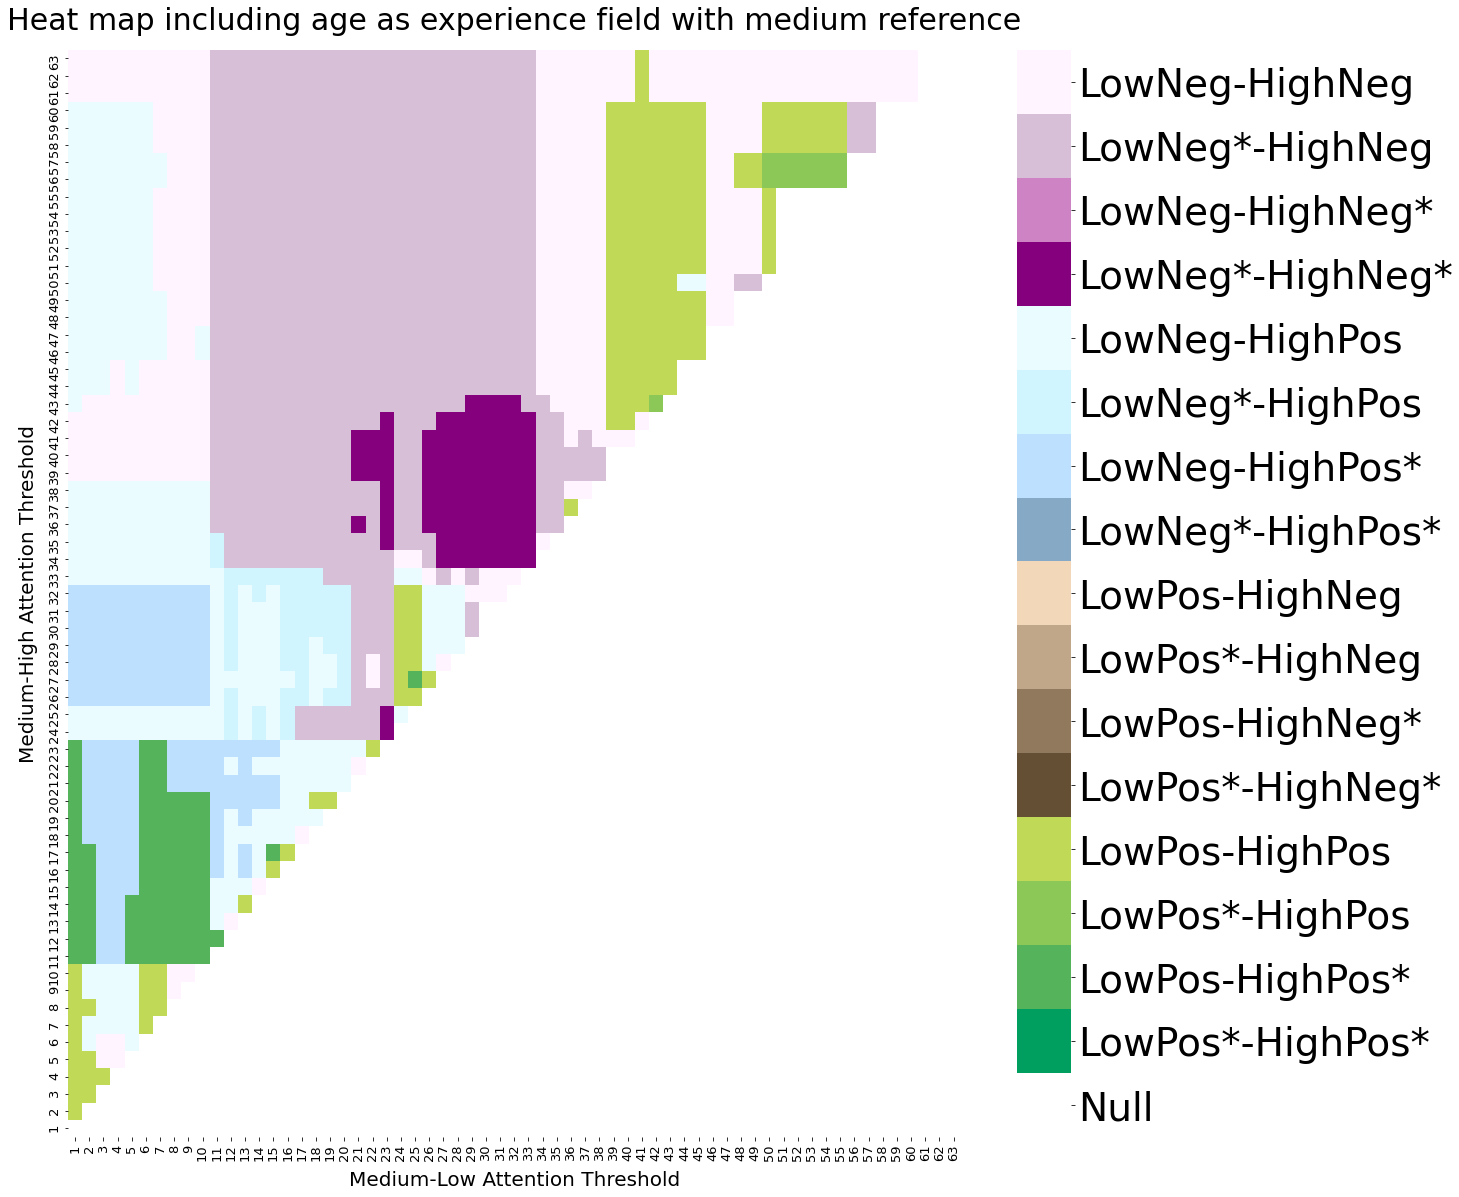

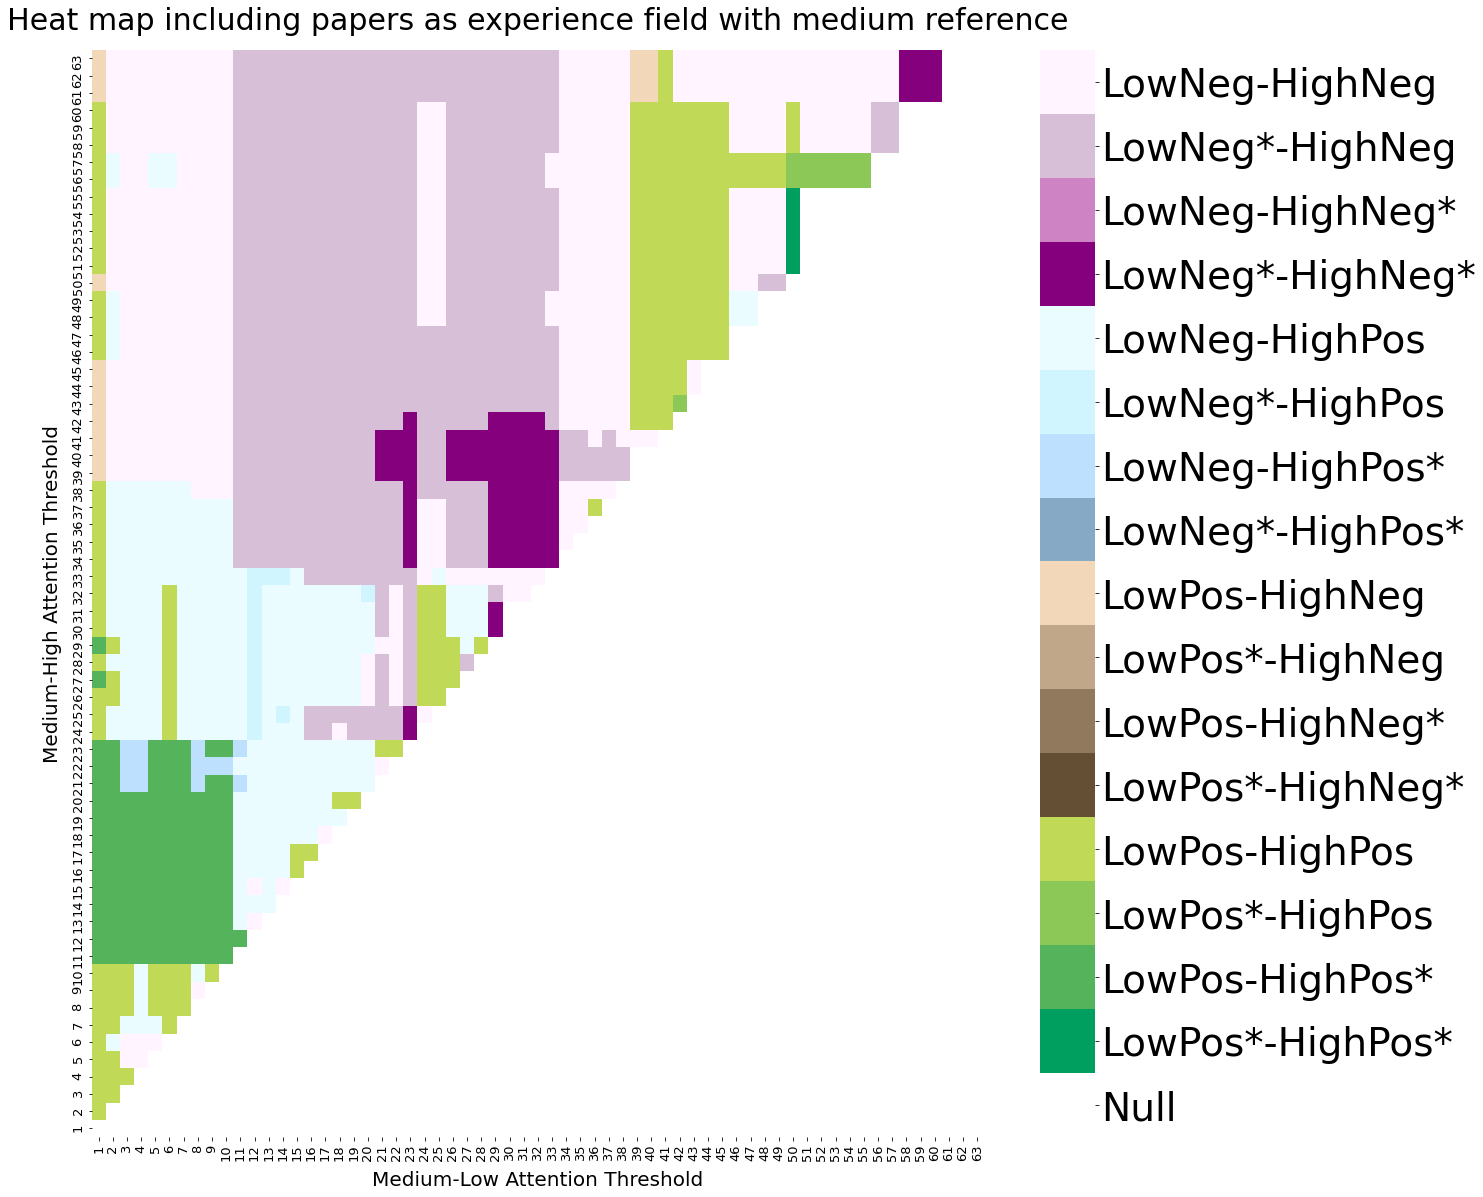

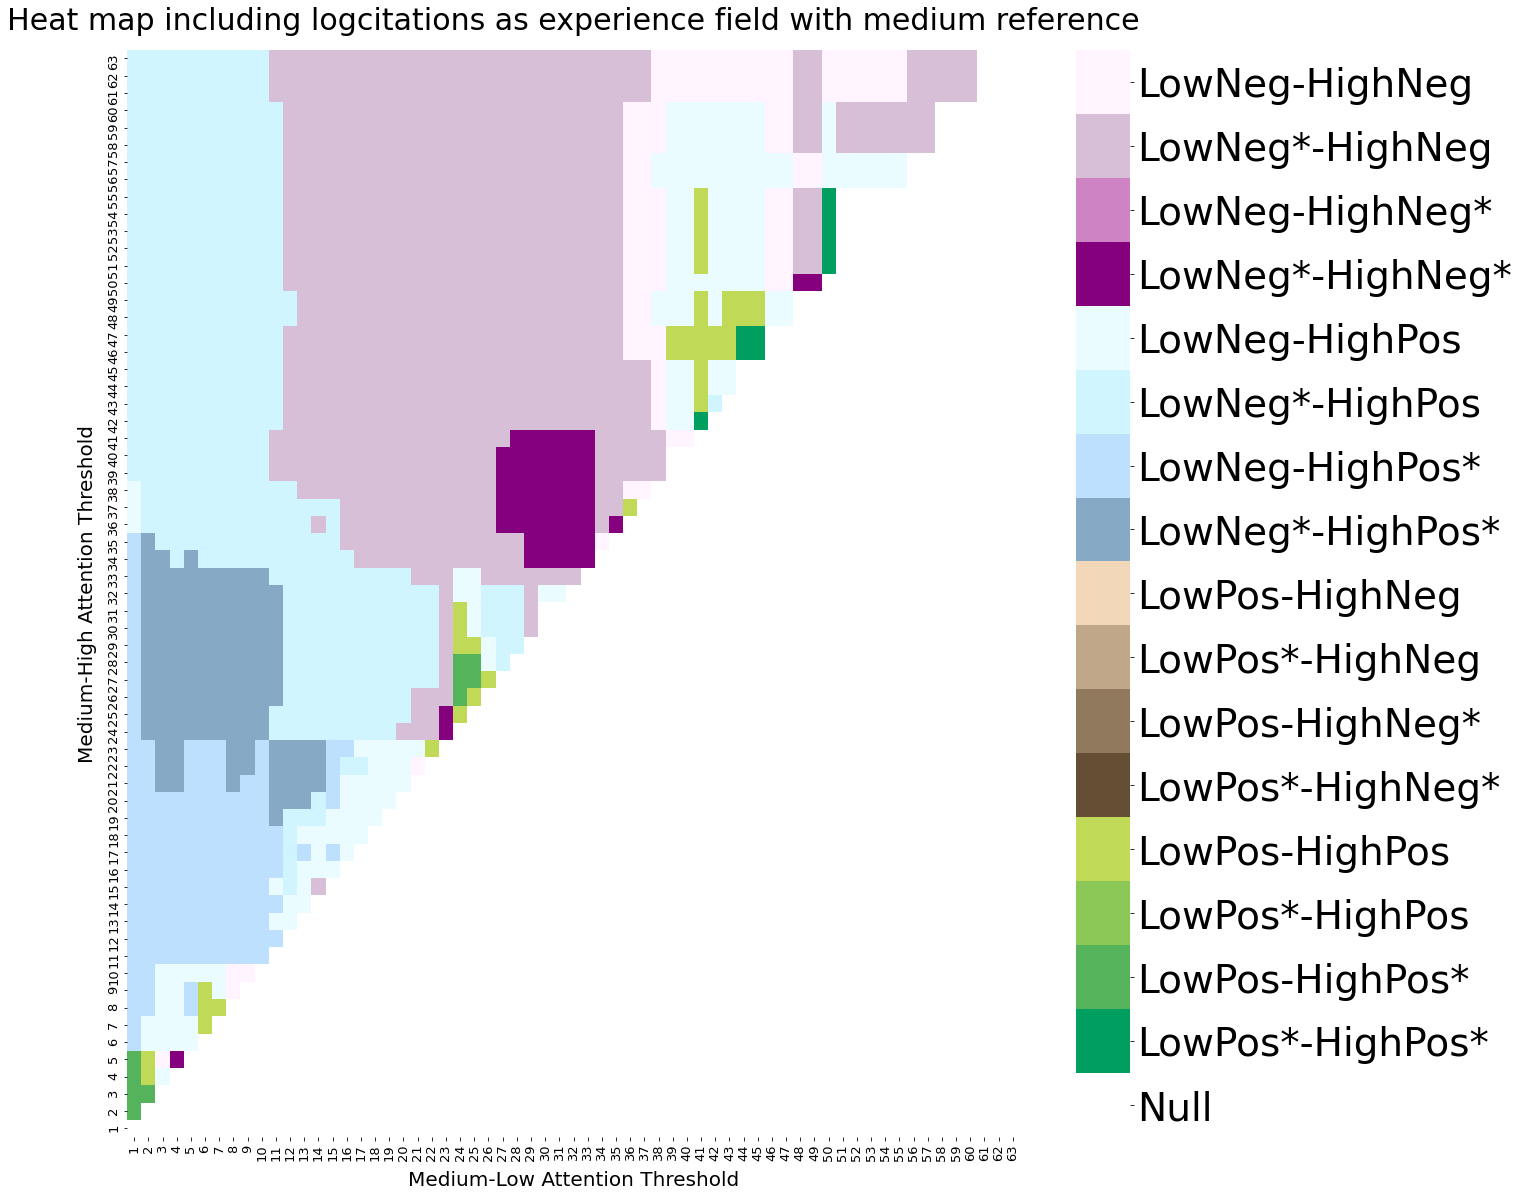

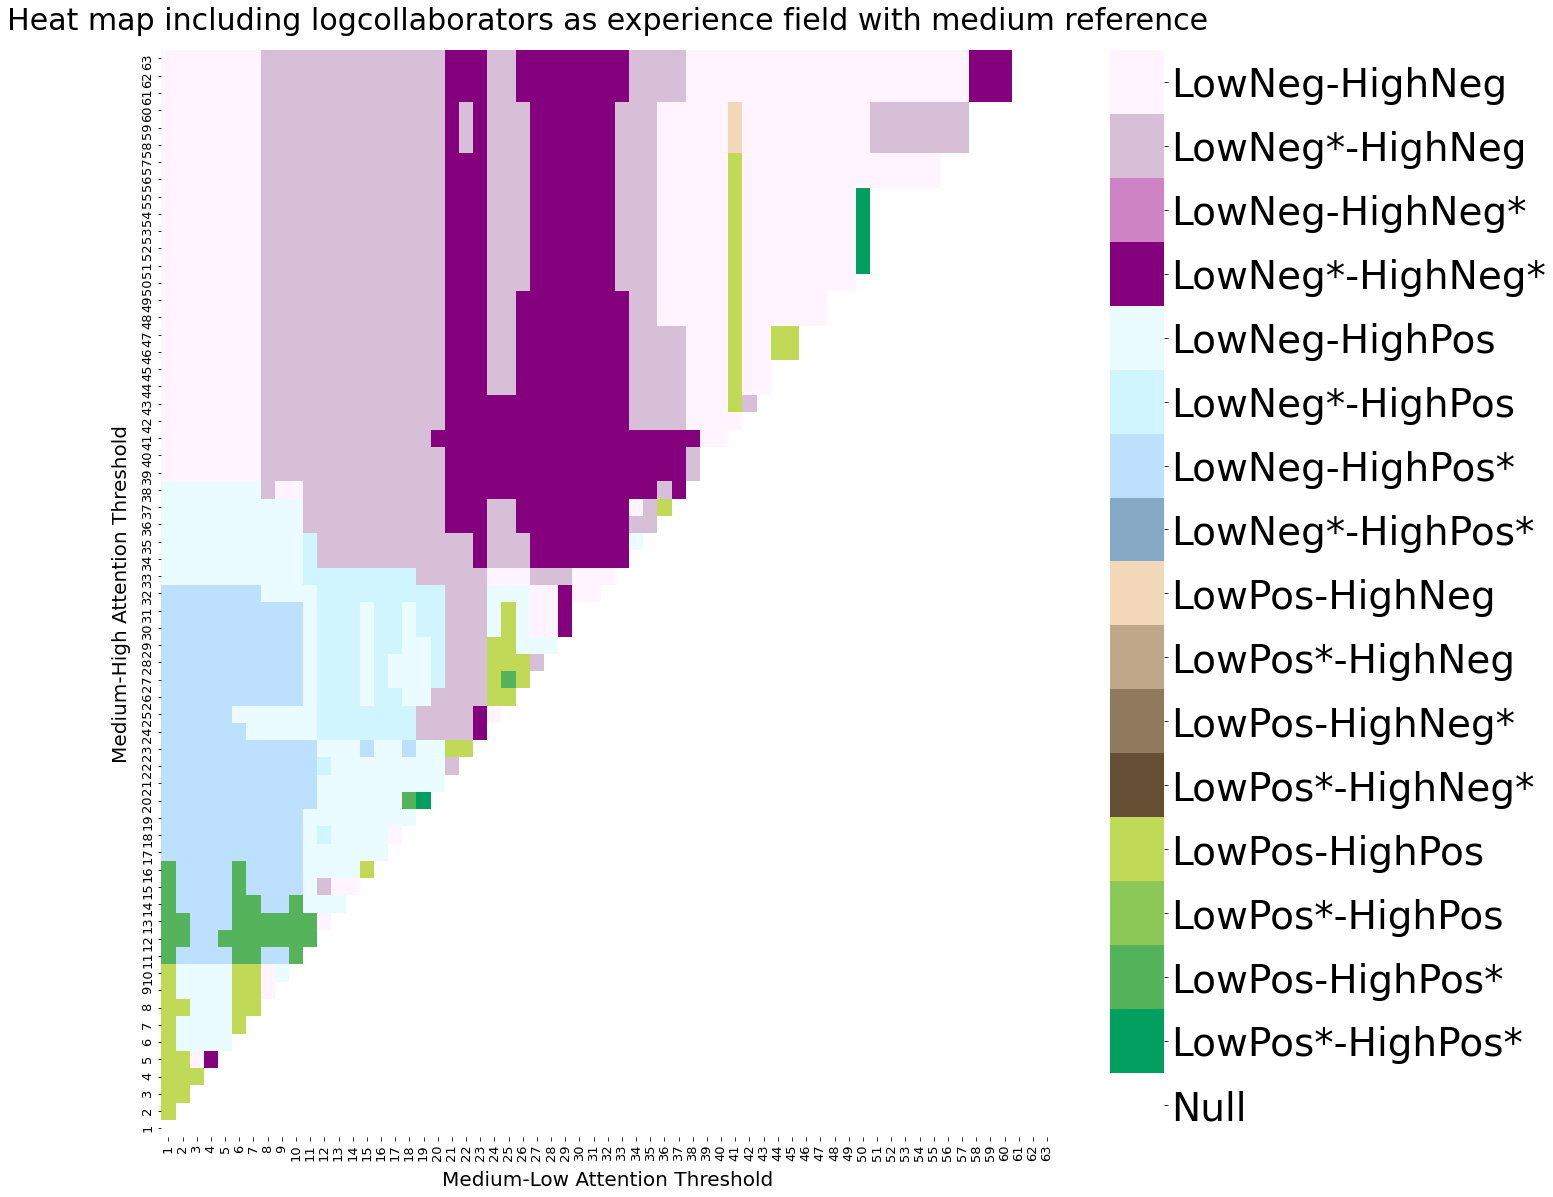

In [39]:
for experience_field in dict_tertiary_altmetric_mediumref.keys():
    
    title = "Heat map including " + experience_field + " as experience field with medium reference"
    
    threshold_dictionary = dict_tertiary_altmetric_mediumref.get(experience_field)
    
    df_threshold, cat_ord_color = prepare_data_2(threshold_dictionary,ub_altmetric)

    create_categorical_heatmap(df_threshold, tupLst_category_order_color=cat_ord_color, title=title,
                              tick_font_size=13)

## Creating the supplementary figures

In [40]:
# Importing relevant libraries

import pandas as pd
import math
from matplotlib.gridspec import GridSpec
import numpy as np

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# For colorbar
import matplotlib.colorbar as colorbar
import matplotlib.colors as clr

# For smoothing
from scipy.ndimage.filters import gaussian_filter

from collections import Counter

In [41]:
def prepare_data(threshold_dictionary, ub, reference_category='medium'):
    
    # This is the dictionary we prepare to create the dataframe for plot
    dict_for_df = {}
    
    # Going through each medium threshold
    for medium in range(1,ub):
        # Initializing the medium threshold list
        dict_for_df[medium] = []
        # Going through each high threshold
        for high in range(1,ub):
            # Let us get the value at this threshold
            paramsMediumOrLow,paramsHigh = threshold_dictionary.get((medium,high),(None,None))
            category = "Null" # This is category for when medium >= high
            
            if not pd.isnull(paramsMediumOrLow):
                # Expanding the tuples
                coefMediumOrLow, pvalMediumOrLow = paramsMediumOrLow
                coefHigh, pvalHigh = paramsHigh
                
                # Defining based on Coefficients
                mediumOrLowCategory = "LowPos" if coefMediumOrLow > 0 else "LowNeg"
                
                if reference_category=='low':
                    mediumOrLowCategory = "MedPos" if coefMediumOrLow > 0 else "MedNeg"
                
                highCategory = "HighPos" if coefHigh > 0 else "HighNeg"
                
                
                # Editing based on p-values
                mediumOrLowCategory = mediumOrLowCategory+"*" if pvalMediumOrLow <= 0.05 else mediumOrLowCategory
                highCategory = highCategory+"*" if pvalHigh <= 0.05 else highCategory
                
                
                category = mediumOrLowCategory + "-" + highCategory
                
                
            # Appending the category in order (order matters)
            dict_for_df[medium].append(category)
        
    cat_ord_color = [('Null',0,'#f5f5f5'),
                ('LowPos*-HighPos*',1,'#00472b'),('LowPos-HighPos*',2,'#54B35B'),
                ('LowPos*-HighPos',3,'#8BC858'),('LowPos-HighPos',4,'#C0DA58'),

                ('LowPos*-HighNeg*',5,'#644F35'),('LowPos-HighNeg*',6,'#91795E'),
                ('LowPos*-HighNeg',7,'#C1A78A'),('LowPos-HighNeg',8,'#F3D7B9'),

                ('LowNeg*-HighPos*',9,'#86A9C5'),('LowNeg-HighPos*',10,'#bde0fe'),
                ('LowNeg*-HighPos',11,'#D0F5FF'),('LowNeg-HighPos',12,'#EAFCFF'),

                ('LowNeg*-HighNeg*',13,'#85007D'),('LowNeg-HighNeg*',14,'#CE84C4'),
                ('LowNeg*-HighNeg',15,'#D8BFD8'),('LowNeg-HighNeg',16,'#FFF4FF')]
    
    return pd.DataFrame(dict_for_df, index=list(range(1,ub))), cat_ord_color

In [42]:
df_thresholds = []

experience_fields = list(dict_tertiary_altmetric_mediumref.keys())

for i in range(len(experience_fields)):
    
    experience_field = experience_fields[i]
    
    threshold_dictionary = dict_tertiary_altmetric_mediumref.get(experience_field)
    
    df_threshold, cat_ord_color = prepare_data(threshold_dictionary,ub_altmetric)
    
    df_thresholds.append(df_threshold)


df_threshold_intersection_3 = df_thresholds[0].copy()
df_threshold_intersection_4 = df_thresholds[0].copy()
categories_in_plot_3 = set()
categories_in_plot_4 = set()

for i in range(1,df_thresholds[0].shape[0]+1): #iterate over rows
    for j in range(1,df_thresholds[0].shape[1]+1): #iterate over columns

        value1 = df_thresholds[0].at[i, j]
        value2 = df_thresholds[1].at[i, j]
        value3 = df_thresholds[2].at[i, j]
        value4 = df_thresholds[3].at[i, j]
        
        most_occuring_val, highest_count = Counter([value1,value2,value3,value4]).most_common(1)[0]
        
        all4same = True if highest_count == 4 else False
        atleast3same = True if highest_count >= 3 else False
        
        if all4same and "*" in most_occuring_val:
            df_threshold_intersection_4.at[i,j] = most_occuring_val
            categories_in_plot_4.add(most_occuring_val)
        else:
            df_threshold_intersection_4.at[i,j] = "Null"
            categories_in_plot_4.add("Null")
            
            
        if atleast3same and "*" in most_occuring_val:
            df_threshold_intersection_3.at[i,j] = most_occuring_val
            categories_in_plot_3.add(most_occuring_val)
        else:
            df_threshold_intersection_3.at[i,j] = "Null"
            categories_in_plot_3.add("Null")

In [43]:
def create_categorical_heatmap(df, axesi, cpfromsns=None, 
                               tupLst_category_order_color=[], tick_font_size=40, title="",
                               spacing_of_tick_labels=2,
                               showcbar=False):
    
    """
    This function will take in the data frame, a tuple list mapping 
    each category to an order (1,2,3..,) and to color, and a tick_font_size 
    which is self-expl.
    """
    
    # converting each value to an integer for the heatmap
    value_to_int = {i:j for (i,j,k) in tupLst_category_order_color}
    
    #value_to_int = {j:i for i,j in enumerate(pd.unique(df.values.ravel()))}
    
    cmap = [color for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]

    # Extracting keys in order
    categories = [cat for (cat,order,color) in sorted(tupLst_category_order_color, key=lambda x: x[1])]
    #print(categories)
    
    # Checking the number of unique values we have for the legend
    n = len(value_to_int)
    
    # discrete colormap (n samples from a given cmap)
    if(cpfromsns):
        cmap = sns.color_palette(cpfromsns, n)
    
    # creating the heatmap
    ax = sns.heatmap(df.replace(value_to_int), 
                     ax=axesi,linewidths=0,
                     cmap=cmap, vmin=0,
                     vmax=len(tupLst_category_order_color),
                     xticklabels=spacing_of_tick_labels,
                     yticklabels=spacing_of_tick_labels,
                     cbar=showcbar) 
    
    # Invertint y-axis for better readability
    axesi.invert_yaxis()

In [44]:
def label_subplots(axi, labeli, xi=-0.1, yi=1.03):
    
    # Labeling the figure so that they can be referred in the paper
    axi.text(xi, yi, labeli, transform=axi.transAxes, fontfamily='fantasy',
      fontsize=200, fontweight='bold')

In [45]:
# Setting up the plot surface
fig = plt.figure(figsize=(160, 90))
gs = GridSpec(nrows=9, ncols=16)
#sns.set(font_scale=8)

# Zeroeth axes for dot plot for retention for full matched sample
ax0 = fig.add_subplot(gs[:4, :4])


# First axes for dot plot for gain for full matched sample
ax1 = fig.add_subplot(gs[4:8, :4], sharex=ax0)

# Second axes for bar plot showing author activity for full matched sample (attrition plot)
ax2 = fig.add_subplot(gs[:4, 4:8], sharey=ax0)


# Fourth axes for dot plot for retention for non-attrited authors
ax3 = fig.add_subplot(gs[4:8, 4:8], sharex=ax2, sharey=ax1)

# Fifth axes for dot plot for gain for non-attrited authors
ax4 = fig.add_subplot(gs[:8, 8:])

ax5 = fig.add_subplot(gs[8:, :])

axesLst = [ax0,ax1,ax2,ax3]

for i in range(len(experience_fields)):
    
    axesi = axesLst[i]
    
    title = "Heat map including " + experience_field + " as experience field with medium reference"
    
    df_threshold = df_thresholds[i]

    create_categorical_heatmap(df_threshold, axesi, tupLst_category_order_color=cat_ord_color, title=title,
                              spacing_of_tick_labels = 5)

            
title = "Heat map of the intersection of atleast 3 experience fields for significant values of attention"

create_categorical_heatmap(df_threshold_intersection_4, ax4, title=title,
                            tupLst_category_order_color=cat_ord_color)

ax0.tick_params(labelbottom=False, labeltop=True, labelsize=80, bottom=False, labelrotation=0)
ax0.tick_params(labelbottom=False, bottom=False, labelrotation=0)
ax1.tick_params(labelbottom=False, bottom=False, labelsize=80, labelrotation=0)
ax2.tick_params(labelbottom=False, bottom=False, left=False, labeltop=True, labelleft=False, labelsize=80, labelrotation=0)
ax3.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False, labelsize=80, labelrotation=0)
ax4.tick_params(labelbottom=False, labeltop=True, bottom=False, labelsize=100, labelrotation=0)

fig.supylabel('Medium-High Threshold', fontsize=150, x=0.02, y=0.6)
fig.supxlabel('Low-Medium Threshold', fontsize=150, y=1.01)

# Now let us add the colorbar

format_dict = {
                0:['LowPos-HighPos','#C0DA58',r'$\beta_{low},\beta_{high}$'],
                1:['LowPos*-HighPos','#8BC858',r'$\beta_{low}^*,\beta_{high}$'],
                2:['LowPos-HighPos*','#54B35B',r'$\beta_{low},\beta_{high}^*$'],
                3:['LowPos*-HighPos*','#00472b',r'$\beta_{low}^*,\beta_{high}^*$'],
                4:['LowPos-HighNeg','#F3D7B9',r'$\beta_{low},-\beta_{high}$'],
                5:['LowPos*-HighNeg','#C1A78A',r'$\beta_{low}^*,-\beta_{high}$'],
                6:['LowPos-HighNeg*','#91795E',r'$\beta_{low},-\beta_{high}^*$'],
                7:['LowPos*-HighNeg*','#644F35',r'$\beta_{low}^*,-\beta_{high}^*$'],
                8:['LowNeg-HighPos','#EAFCFF',r'$-\beta_{low},\beta_{high}$'],
                9:['LowNeg*-HighPos','#D0F5FF',r'$-\beta_{low}^*,\beta_{high}$'],
                10:['LowNeg-HighPos*','#bde0fe',r'$-\beta_{low},\beta_{high}^*$'],
                11:['LowNeg*-HighPos*','#86A9C5',r'$-\beta_{low}^*,\beta_{high}^*$'],
                12:['LowNeg-HighNeg','#FFF4FF',r'$-\beta_{low},-\beta_{high}$'],
                13:['LowNeg*-HighNeg','#D8BFD8',r'$-\beta_{low}^*,-\beta_{high}$'],
                14:['LowNeg-HighNeg*','#CE84C4',r'$-\beta_{low},-\beta_{high}^*$'],
                15:['LowNeg*-HighNeg*','#85007D',r'$-\beta_{low}^*,-\beta_{high}^*$']
}

cb_colors = [color for (category,color,label) in format_dict.values()]
num_colors = len(cb_colors)
cmap_ = clr.ListedColormap(cb_colors)


cb = colorbar.ColorbarBase(ax5, orientation='horizontal',
                           cmap=cmap_, norm=plt.Normalize(-0.5, num_colors - 0.5))

cb.set_ticks(range(num_colors))

labels = [label for (category,color,label) in format_dict.values()]

cb.ax.set_xticklabels(labels, fontsize=80)

cb.outline.set_visible(False)


# Annotating figures
label_subplots(ax0, "a")
label_subplots(ax1, "c")
label_subplots(ax2, "b")
label_subplots(ax3, "d")
label_subplots(ax4, "e", xi=-0.07, yi=1.01)

ax5.annotate("Both low and high attention are in direct\n"\
             "    relationship with attrition w.r.t\n"\
             "               medium attention.",
            fontsize=100, xy=(0.09, 0.03), xycoords='figure fraction')

ax5.annotate("Low and high attention are respectively\n" 
             " in direct and inverse relationship with\n"
             "    attrition w.r.t medium attention",
            fontsize=100, xy=(0.32, 0.03), xycoords='figure fraction')

ax5.annotate("Low and high attention are respectively\n" 
             " in inverse and direct relationship with\n"
             "    attrition w.r.t medium attention",
            fontsize=100, xy=(0.55, 0.03), xycoords='figure fraction')

ax5.annotate("Both low and high attention are in inverse\n"\
             "    relationship with attrition w.r.t\n"\
             "               medium attention.",
            fontsize=100, xy=(0.76, 0.03), xycoords='figure fraction')

plt.tight_layout(pad=10)
plt.savefig('heatmaps_logistic_attrition_wSJR.svg',dpi=1200)
